# Assembling FLEX dataset
This might be the last model we need to train! We've done a DEF model, a K model and a QB model. We thought we'd have to do separate models for TE, WR and RB. But all of those positions are eligible for the flex position, and RBs often catch passes just like WRs. Wide receivers run the ball, not as frequently as RBs catch passes, but generally TEs, WRs and RBs are in the same pool.<br>

We look at target share for WRs and TEs and we want to account for every pass that is thrown. To do that, we need to include RBs. So hopefully this is the last of four models that compose our NFL daily fantasy model.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl
#import itertools

In [2]:
import sqlite3

# Pulling from database
Fetching from database. We're filtering out data from before 2006 because air_yards isn't included. We did the same thing for quarterbacks. So the data we use for our kickers and defense goes back to 2000, but only 2006 for QB, RB, WR and TE.

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

query_weekly = "SELECT * FROM weekly_data WHERE season >= 2006"
query_spread = "SELECT * FROM spreads_totals WHERE season >= 2006"
#query_pbp = "SELECT * FROM pbp_non_defense WHERE season >= 2006"
query_rb_wr_te = "SELECT * FROM rb_wr_te_data WHERE season >= 2006"

weekly_df = pd.read_sql_query(query_weekly, conn)
spread_df = pd.read_sql_query(query_spread, conn)
#pbp_df = pd.read_sql_query(query_pbp, conn)
rb_wr_te_df = pd.read_sql_query(query_rb_wr_te, conn)

# Close the database connection
conn.close()

This is weekly data for each player. We can use this to calculate fantasy points for most players.

In [4]:
weekly_df.head()

,id,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,29780,00-0000108,None,David Akers,K,SPEC,None,PHI,2006,4,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,0.44,0.44
1,29781,00-0000166,None,Stephen Alexander,TE,TE,None,DEN,2006,1,...,1.0,2.368354,0,4.800000,0.153846,0.063291,0.275073,0.0,2.40,4.40
2,29782,00-0000166,None,Stephen Alexander,TE,TE,None,DEN,2006,2,...,0.0,-0.767547,0,0.000000,0.125000,0.000000,0.187500,0.0,0.80,2.80
3,29783,00-0000166,None,Stephen Alexander,TE,TE,None,DEN,2006,3,...,1.0,1.447806,0,2.000000,0.066667,0.097561,0.168293,0.0,2.40,3.40
4,29784,00-0000166,None,Stephen Alexander,TE,TE,None,DEN,2006,10,...,3.0,3.127105,0,1.814815,0.300000,0.219512,0.603659,0.0,4.90,10.90


Point spreads, totals, binary variables for grass surface and outdoor game

In [5]:
spread_df.head()

,season,week,game_id,team,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
0,2006,1,2006_01_ATL_CAR,ATL,CAR,-4.5,39.0,1,1,0,17.25,21.75
1,2006,1,2006_01_ATL_CAR,CAR,ATL,4.5,39.0,1,1,1,21.75,17.25
2,2006,1,2006_01_BAL_TB,BAL,TB,-3.0,33.0,1,1,0,15.00,18.00
3,2006,1,2006_01_BAL_TB,TB,BAL,3.0,33.0,1,1,1,18.00,15.00
4,2006,1,2006_01_BUF_NE,BUF,NE,-10.0,41.0,1,1,0,15.50,25.50


One subset of the 390 columns from the play-by-play data. We'll use this to get wind factors and division game binaries.

In [6]:
#pbp_df.head()

Another subset of the play-by-play data. We'll use this to hopefully find the players who are missing in the weekly data. There also are variables we can derive from this such as red-zone data and such.

In [7]:
rb_wr_te_df.head()

,play_id,game_id,home_team,away_team,week,posteam,posteam_type,defteam,side_of_field,yardline_100,...,rush,passer_id,rusher_id,receiver_id,name,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id
0,1.0,2006_01_ATL_CAR,CAR,ATL,1,None,None,None,None,NaN,...,0.0,None,None,None,None,None,None,None,None,None
1,36.0,2006_01_ATL_CAR,CAR,ATL,1,ATL,away,CAR,CAR,30.0,...,0.0,None,None,None,None,None,None,None,None,None
2,58.0,2006_01_ATL_CAR,CAR,ATL,1,ATL,away,CAR,ATL,67.0,...,1.0,None,00-0004640,None,W.Dunn,00-0004640,W.Dunn,00-0004640,W.Dunn,00-0004640
3,80.0,2006_01_ATL_CAR,CAR,ATL,1,ATL,away,CAR,ATL,62.0,...,1.0,None,00-0004640,None,W.Dunn,00-0004640,W.Dunn,00-0004640,W.Dunn,00-0004640
4,102.0,2006_01_ATL_CAR,CAR,ATL,1,ATL,away,CAR,ATL,63.0,...,0.0,00-0020245,None,00-0020285,M.Vick,00-0020245,A.Crumpler,00-0020285,A.Crumpler,00-0020285


In [8]:
rb_wr_te_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857073 entries, 0 to 857072
Data columns (total 95 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   play_id                        857073 non-null  float64
 1   game_id                        857073 non-null  object 
 2   home_team                      857073 non-null  object 
 3   away_team                      857073 non-null  object 
 4   week                           857073 non-null  int64  
 5   posteam                        812692 non-null  object 
 6   posteam_type                   812692 non-null  object 
 7   defteam                        812692 non-null  object 
 8   side_of_field                  797302 non-null  object 
 9   yardline_100                   797869 non-null  float64
 10  sp                             857073 non-null  float64
 11  down                           723061 non-null  float64
 12  goal_to_go                    

In [9]:
nfl.see_weekly_cols()

Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost',
       'rushing_first_downs', 'rushing_epa', 'rushing_2pt_conversions',
       'receptions', 'targets', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards',
       'receiving_yards_after_catch', 'receiving_first_downs', 'receiving_epa',
       'receiving_2pt_conversions', 'racr', 'target_share', 'air_yards_share',
       'wopr', 'special_teams_tds', 'fantasy_points

In [10]:
# qb_cols = ['player_id', 'player_name', 'player_display_name', 'position', 'recent_team', 'season', 'week',\
#  'season_type', 'opponent_team', 'completions', 'attempts',\
#  'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',\
#  'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',\
#  'passing_yards_after_catch', 'passing_epa',\
#  'passing_2pt_conversions', 'pacr', 'dakota', 'carries', 'rushing_yards',\
#  'rushing_tds', 'rushing_fumbles', 'rushing_fumbles_lost', 'rushing_2pt_conversions',\
#  'receptions', 'receiving_yards', 'receiving_tds',\
#  'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'racr', 'fantasy_points', 'fantasy_points_ppr']

In [11]:
seasons = list(np.arange(2000, 2024, 1))

In [12]:
# nfl_weekly = nfl.import_weekly_data(seasons)

# Our first hurdle
The weekly data, while convenient, might not have every player who has had a carry or been targeted for a pass. That's a problem because we need accurate target shares and RB workloads as features in the model. We can't get an accurate target share if the weekly data doesn't include every player who had a pass thrown to him.<br>

We could then calculate the dataset for our model with the play-by-play data, but that data doesn't include player positions. We need that because we want defense-vs-position (DvP) features.<br>

So perhaps we should start with the weekly data.

## Aug. 24 update

It has proven quite challenging to extract play-by-play data to fill in the blanks of the weekly data. So we might just use the pbp data to add variables such as carries and goal-to-go carries. We can get these by doing a left join with the weekly data.

It might be a different story when we deploy the data live. We'll want to have a data point for every available player on FanDuel and DraftKings. This might be easier since we'll only be looking at data from the last eight games. But we're not going to worry about that until we run the model live. Right now, we need a model, and the weekly dataframe provides plenty of data for that.

In [13]:
weekly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94928 entries, 0 to 94927
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           94928 non-null  int64  
 1   player_id                    94928 non-null  object 
 2   player_name                  61015 non-null  object 
 3   player_display_name          94928 non-null  object 
 4   position                     94859 non-null  object 
 5   position_group               94859 non-null  object 
 6   headshot_url                 68591 non-null  object 
 7   recent_team                  94928 non-null  object 
 8   season                       94928 non-null  int64  
 9   week                         94928 non-null  int64  
 10  season_type                  94928 non-null  object 
 11  opponent_team                94928 non-null  object 
 12  completions                  94928 non-null  int64  
 13  attempts        

In [14]:
weekly_df['position_group'].value_counts()

position_group
WR      36479
RB      27536
TE      18313
QB      11607
SPEC      318
DB        308
OL        140
LB         99
DL         59
Name: count, dtype: int64

In [15]:
weekly_df['position'].value_counts()

position
WR     36479
RB     24379
TE     18267
QB     11607
FB      3190
P        293
CB       108
FS        79
T         72
SS        68
DB        52
OLB       44
G         30
ILB       29
K         24
DE        23
LB        21
C         18
OT        16
DL        15
DT        14
HB        13
NT         7
MLB        5
OL         2
OG         2
LS         1
S          1
Name: count, dtype: int64

Weekly data filtered for RBs, WRs and TEs

In [16]:
flex_df = weekly_df[weekly_df['position'].isin(['RB', 'HB', 'FB', 'WR', 'TE'])]

In [17]:
cols_to_group = ['season', 'week', 'recent_team', 'opponent_team', 'player_id', 'player_display_name', 'position']

So we do have quite a few duplicate names so player_id becomes more important than names.

In [18]:
# Group by 'player_display_name' and check the number of unique 'player_id's
duplicate_names = flex_df.groupby('player_display_name')['player_id'].nunique()

# Filter the results to find names associated with more than one unique ID
duplicate_names = duplicate_names[duplicate_names > 1]

In [19]:
duplicate_names

player_display_name
Adrian Peterson    2
Cedrick Wilson     2
Chris Davis        2
Chris Henry        2
Chris Thompson     2
David Johnson      2
Kevin Smith        2
Matt Jones         2
Michael Pittman    2
Mike Thomas        2
Mike Williams      3
Rod Smith          2
Rodney Smith       2
Ryan Grant         2
Steve Smith        2
Zach Miller        2
Name: player_id, dtype: int64

In [20]:
scoring_cols = ['passing_yards', 'passing_tds', 'interceptions', 'passing_2pt_conversions', 'rushing_yards',\
                   'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions', 'receptions', 'receiving_yards',\
                   'receiving_tds', 'receiving_fumbles_lost', 'receiving_2pt_conversions', 'sack_fumbles_lost', 'special_teams_tds',\
               'targets', 'carries', 'receiving_yards_after_catch', 'receiving_air_yards', 'air_yards_share', 'target_share']

In [21]:
flex_df = flex_df.groupby(cols_to_group)[scoring_cols].sum()

In [22]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 82328 entries, (2006, 1, 'ARI', 'SF', '00-0008241', 'Edgerrin James', 'RB') to (2023, 22, 'SF', 'KC', '00-0036567', 'Elijah Mitchell', 'RB')
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   passing_yards                82328 non-null  float64
 1   passing_tds                  82328 non-null  int64  
 2   interceptions                82328 non-null  float64
 3   passing_2pt_conversions      82328 non-null  int64  
 4   rushing_yards                82328 non-null  float64
 5   rushing_tds                  82328 non-null  int64  
 6   rushing_fumbles_lost         82328 non-null  float64
 7   rushing_2pt_conversions      82328 non-null  int64  
 8   receptions                   82328 non-null  int64  
 9   receiving_yards              82328 non-null  float64
 10  receiving_tds                82328 non-null  int64  
 11  receiving_fumbles

In [23]:
flex_df

passing_yards  \
season week recent_team opponent_team player_id  player_display_name position                  
2006   1    ARI         SF            00-0008241 Edgerrin James      RB                  0.0   
                                      00-0019552 Troy Walters        WR                  0.0   
                                      00-0022084 Anquan Boldin       WR                  0.0   
                                      00-0022156 Bryant Johnson      WR                  0.0   
                                      00-0022921 Larry Fitzgerald    WR                  0.0   
...                                                                                      ...   
2023   22   SF          KC            00-0034407 Ray-Ray McCloud     WR                  0.0   
                                      00-0035719 Deebo Samuel        WR                  0.0   
                                      00-0036259 Jauan Jennings      WR                 21.0   
                                      00-0036261 Brandon Aiyuk       WR                  0.0   
                                      00-0036567 Elijah Mitchell     RB                  0.0   

                                                                               passing_tds  \
season week recent_team opponent_team player_id  player_display_name position                
2006   1    ARI         SF            00-0008241 Edgerrin James      RB                  0   
                                      00-0019552 Troy Walters        WR                  0   
                                      00-0022084 Anquan Boldin       WR                  0   
                                      00-0022156 Bryant Johnson      WR                  0   
                                      00-0022921 Larry Fitzgerald    WR                  0   
...                                                                                    ...   
2023   22   SF          KC            00-0034407 Ray-Ray McCloud     WR                  0   
                                      00-0035719 Deebo Samuel        WR                  0   
                                      00-0036259 Jauan Jennings      WR                  1   
                                      00-0036261 Brandon Aiyuk       WR                  0   
                                      00-0036567 Elijah Mitchell     RB                  0   

                                                                               interceptions  \
season week recent_team opponent_team player_id  player_display_name position                  
2006   1    ARI         SF            00-0008241 Edgerrin James      RB                  0.0   
                                      00-0019552 Troy Walters        WR                  0.0   
                                      00-0022084 Anquan Boldin       WR                  0.0   
                                      00-0022156 Bryant Johnson      WR                  0.0   
                                      00-0022921 Larry Fitzgerald    WR                  0.0   
...                                                                                      ...   
2023   22   SF          KC            00-0034407 Ray-Ray McCloud     WR                  0.0   
                                      00-0035719 Deebo Samuel        WR                  0.0   
                                      00-0036259 Jauan Jennings      WR                  0.0   
                                      00-0036261 Brandon Aiyuk       WR                  0.0   
                                      00-0036567 Elijah Mitchell     RB                  0.0   

                                                                               passing_2pt_conversions  \
season week recent_team opponent_team player_id  player_display_name position                            
2006   1    ARI         SF            00-0008241 Edgerrin James      RB                              0   
                                      00

In [24]:
def replace(code, old, new):
    """
    Basically a find and replace
    """
    return code.replace(old, new)

In [25]:
flex_df.reset_index(inplace = True, drop = False)

In [26]:
#There are a few errant rows where the opponent matches the team
flex_df = flex_df[~(flex_df['recent_team'] == flex_df['opponent_team'])]

In [27]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 82260 entries, 0 to 82327
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   passing_yards                82260 non-null  float64
 8   passing_tds                  82260 non-null  int64  
 9   interceptions                82260 non-null  float64
 10  passing_2pt_conversions      82260 non-null  int64  
 11  rushing_yards                82260 non-null  float64
 12  rushing_tds                  82260 non-null  int64  
 13  rushing_fumbles_lost 

# What do we need from play-by-play?
Let's take a look at the data we'd like to have and see where we need to integrate the play-by-play data. We have yards_after_catch and air_yards. We have targets and target share. Even though the target share doesn't add up to 100 percent, it's still useful. We'll definitely want to spot-check that.<br>

We have carries but no carry share. Maybe we need to just take the total carries for each team in each game from the pbp and join that with the flex_df. That shouldn't be too hard. Then we can figure out every RBs workload even if they don't all add up to 100.<br>

We also want goal_to_go binary for each play to see how many carries or targets a player gets in goal-line situations and also the rate at which they score TDs in those situations.<br>

So let's start by using the pbp data to get the total carries for every team in every game since 2006.

In [28]:
run_df = rb_wr_te_df[rb_wr_te_df['play_type'] == 'run']

In [29]:
running_play_counts = run_df.groupby(['season', 'week', 'posteam', 'defteam', 'game_id']).size().reset_index(name='total_carries')

In [30]:
running_play_counts.rename(columns = {'posteam' : 'recent_team', 'defteam': 'opponent_team'}, inplace = True)

In [31]:
flex_merge = pd.merge(flex_df, running_play_counts, on = ['season', 'week', 'recent_team', 'opponent_team'], how = 'left')

Let's just check five random rows to make sure that total_carries looks right

In [32]:
rand_check = [117, 25348, 39329, 57928, 79422]

In [33]:
for num in rand_check:
    team = flex_merge.loc[num, 'recent_team']
    carries = flex_merge.loc[num, 'total_carries']
    season = flex_merge.loc[num, 'season']
    week = flex_merge.loc[num, 'week']
    print(f"{team} had {carries} total carries in Week {week} of the {season} season")

LA had 25 total carries in Week 1 of the 2006 season
NYG had 25 total carries in Week 16 of the 2011 season
GB had 38 total carries in Week 17 of the 2014 season
NE had 27 total carries in Week 17 of the 2018 season
TB had 17 total carries in Week 8 of the 2023 season


In [34]:
#This check prompts other checks within these games
#Make sure Rams  JAckson had 22 carries in Week 1 of 2006 
#Brandon Jacobs 7 carries in Week 16 of 2011
#Eddy LAcy 26 carries Week 17 2014
#Julian Edelman 2 carries Week 17 2018
#Baker MAyfield 3 carries Week 8 2023
#KeShaun Vaughn 1 carry Week 8 2023

In [35]:
flex_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   passing_yards                82260 non-null  float64
 8   passing_tds                  82260 non-null  int64  
 9   interceptions                82260 non-null  float64
 10  passing_2pt_conversions      82260 non-null  int64  
 11  rushing_yards                82260 non-null  float64
 12  rushing_tds                  82260 non-null  int64  
 13  rushing_fumbles_

In [36]:
flex_merge['carry_share'] = round(flex_merge['carries']/flex_merge['total_carries'], 3)

In [37]:
flex_merge.head()

,season,week,recent_team,opponent_team,player_id,player_display_name,position,passing_yards,passing_tds,interceptions,...,special_teams_tds,targets,carries,receiving_yards_after_catch,receiving_air_yards,air_yards_share,target_share,game_id,total_carries,carry_share
0,2006,1,ARI,SF,00-0008241,Edgerrin James,RB,0.0,0,0.0,...,0.0,3,26,15.0,-2.0,-0.013699,0.130435,2006_01_SF_ARI,29,0.897
1,2006,1,ARI,SF,00-0019552,Troy Walters,WR,0.0,0,0.0,...,0.0,2,0,7.0,8.0,0.054795,0.086957,2006_01_SF_ARI,29,0.000
2,2006,1,ARI,SF,00-0022084,Anquan Boldin,WR,0.0,0,0.0,...,0.0,4,0,48.0,14.0,0.095890,0.173913,2006_01_SF_ARI,29,0.000
3,2006,1,ARI,SF,00-0022156,Bryant Johnson,WR,0.0,0,0.0,...,0.0,2,0,33.0,18.0,0.123288,0.086957,2006_01_SF_ARI,29,0.000
4,2006,1,ARI,SF,00-0022921,Larry Fitzgerald,WR,0.0,0,0.0,...,0.0,9,0,27.0,106.0,0.726027,0.391304,2006_01_SF_ARI,29,0.000


In [38]:
flex_merge.tail(30)

,season,week,recent_team,opponent_team,player_id,player_display_name,position,passing_yards,passing_tds,interceptions,...,special_teams_tds,targets,carries,receiving_yards_after_catch,receiving_air_yards,air_yards_share,target_share,game_id,total_carries,carry_share
82230,2023,21,KC,BAL,00-0036360,Clyde Edwards-Helaire,RB,0.0,0,0.0,...,0.0,2,1,9.0,-6.0,-0.028169,0.055556,2023_21_KC_BAL,29,0.034
82231,2023,21,KC,BAL,00-0036637,Noah Gray,TE,0.0,0,0.0,...,0.0,5,0,8.0,35.0,0.164319,0.138889,2023_21_KC_BAL,29,0.000
82232,2023,21,KC,BAL,00-0037197,Isiah Pacheco,RB,0.0,0,0.0,...,0.0,4,24,16.0,-2.0,-0.009390,0.111111,2023_21_KC_BAL,29,0.828
82233,2023,21,KC,BAL,00-0039067,Rashee Rice,WR,0.0,0,0.0,...,0.0,9,0,46.0,41.0,0.192488,0.250000,2023_21_KC_BAL,29,0.000
82234,2023,21,SF,DET,00-0029892,Kyle Juszczyk,FB,0.0,0,0.0,...,0.0,3,1,5.0,32.0,0.112676,0.100000,2023_21_DET_SF,31,0.032
82235,2023,21,SF,DET,00-0033280,Christian McCaffrey,RB,0.0,0,0.0,...,0.0,5,20,33.0,11.0,0.038732,0.166667,2023_21_DET_SF,31,0.645
82236,2023,21,SF,DET,00-0033288,George Kittle,TE,0.0,0,0.0,...,0.0,3,0,14.0,35.0,0.123239,0.100000,2023_21_DET_SF,31,0.000
82237,2023,21,SF,DET,00-0035719,Deebo Samuel,WR,0.0,0,0.0,...,0.0,9,3,65.0,40.0,0.140845,0.300000,2023_21_DET_SF,31,0.097
82238,2023,21,SF,DET,00-0036259,Jauan Jennings,WR,0.0,0,0.0,...,0.0,2,0,1.0,32.0,0.112676,0.066667,2023_21_DET_SF,31,0.000
82239,2023,21,SF,DET,00-0036261,Brandon Aiyuk,WR,0.0,0,0.0,...,0.0,8,0,3.0,134.0,0.471831,0.266667,2023_21_DET_SF,31,0.000


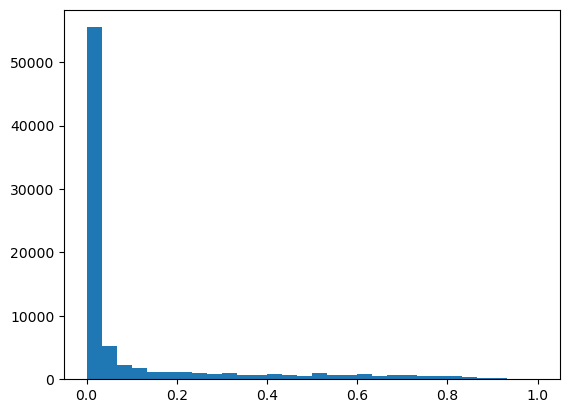

In [39]:
plt.hist(flex_merge['carry_share'], bins = 30)
plt.show;

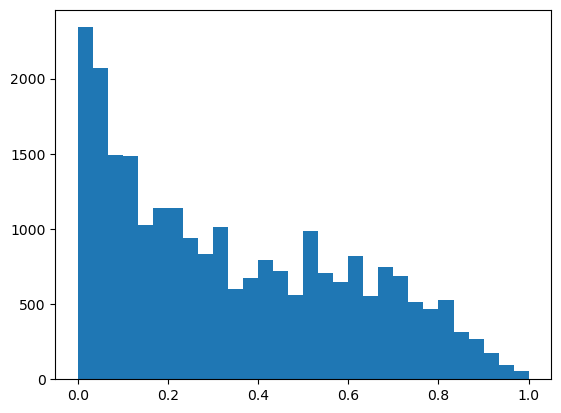

In [40]:
plt.hist(flex_merge[flex_merge['position'] == 'RB']['carry_share'], bins = 30)
plt.show();

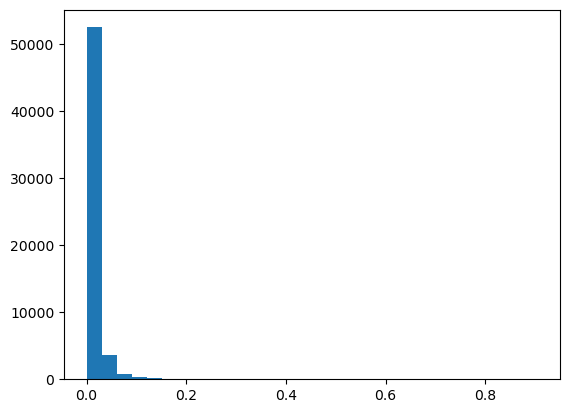

In [41]:
plt.hist(flex_merge[flex_merge['position'] != 'RB']['carry_share'], bins = 30)
plt.show();

# Goal-to-go situations
We'll filter the pbp data by rows in which goal_to_go is True and the play is either a run or a pass. We find that on passing plays, some of the receiver_player_id values are null, but for running plays none of them are null. This implies that on plays in which the QB is sacked, no pass is thrown so there's no receiver.<br>

Those plays probably should be discarded as we are looking for a percentage of times a RB-WR-TE gets the ball in goal-to-go situations. When a QB is sacked, no one gets the ball.<br>

**Update:** goal_to_go leaves out situations where it's 3rd and 2 from the 4-yard line. Maybe we should see if filtering by yardline_100 <= 10 gives us more data points.

In [42]:
gtg_df_10 = rb_wr_te_df[(rb_wr_te_df['yardline_100'] <= 10) & ((rb_wr_te_df['play_type'] == 'run') | (rb_wr_te_df['play_type'] == 'pass'))]
#gtg_df = rb_wr_te_df[(rb_wr_te_df['goal_to_go'] == True) & ((rb_wr_te_df['play_type'] == 'run') | (rb_wr_te_df['play_type'] == 'pass'))]

In [43]:
gtg_df_10['play_type'].value_counts()

play_type
run     21931
pass    21582
Name: count, dtype: int64

In [44]:
gtg_df_10 = gtg_df_10[(gtg_df_10['receiver_player_id'].notnull()) | (gtg_df_10['rusher_player_id'].notnull())]
#gtg_df = gtg_df[(gtg_df['receiver_player_id'].notnull()) | (gtg_df['rusher_player_id'].notnull())]

In [45]:
gtg_df_10[(gtg_df_10['receiver_player_id'].isnull()) & (gtg_df_10['rusher_player_id'].isnull())]
#gtg_df[(gtg_df['receiver_player_id'].isnull()) & (gtg_df['rusher_player_id'].isnull())]

,play_id,game_id,home_team,away_team,week,posteam,posteam_type,defteam,side_of_field,yardline_100,...,rush,passer_id,rusher_id,receiver_id,name,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id


In [46]:
gtg_df_10[(gtg_df_10['receiver_player_id'].notnull()) & (gtg_df_10['rusher_player_id'].notnull())]
#gtg_df[(gtg_df['receiver_player_id'].notnull()) & (gtg_df['rusher_player_id'].notnull())]

,play_id,game_id,home_team,away_team,week,posteam,posteam_type,defteam,side_of_field,yardline_100,...,rush,passer_id,rusher_id,receiver_id,name,id,fantasy_player_name,fantasy_player_id,fantasy,fantasy_id


In [47]:
gtg_df_10['player_id'] = gtg_df_10['rusher_player_id'].fillna(gtg_df_10['receiver_player_id'])
#gtg_df['player_id'] = gtg_df['rusher_player_id'].fillna(gtg_df['receiver_player_id'])

In [48]:
gtg_df_10.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40444 entries, 33 to 857071
Data columns (total 96 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   play_id                        40444 non-null  float64
 1   game_id                        40444 non-null  object 
 2   home_team                      40444 non-null  object 
 3   away_team                      40444 non-null  object 
 4   week                           40444 non-null  int64  
 5   posteam                        40444 non-null  object 
 6   posteam_type                   40444 non-null  object 
 7   defteam                        40444 non-null  object 
 8   side_of_field                  40444 non-null  object 
 9   yardline_100                   40444 non-null  float64
 10  sp                             40444 non-null  float64
 11  down                           38913 non-null  float64
 12  goal_to_go                     40444 non-null  fl

In [49]:
#Total goal to go situations for each team in each game
grouped_gtg_10 = gtg_df_10.groupby(['season', 'week', 'posteam', 'defteam']).size().reset_index(name = 'plays_in_10')

#grouped_gtg = gtg_df.groupby(['season', 'week', 'posteam', 'defteam']).size().reset_index(name = 'gtg_plays')


In [50]:
gtg_df_10.columns

Index(['play_id', 'game_id', 'home_team', 'away_team', 'week', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'sp',
       'down', 'goal_to_go', 'yrdln', 'ydstogo', 'desc', 'play_type',
       'yards_gained', 'air_yards', 'yards_after_catch',
       'two_point_conv_result', 'td_team', 'td_player_name', 'td_player_id',
       'posteam_score', 'defteam_score', 'incomplete_pass', 'fumble_forced',
       'fumble_not_forced', 'fumble_lost', 'rush_attempt', 'pass_attempt',
       'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown',
       'two_point_attempt', 'fumble', 'complete_pass', 'passer_player_id',
       'passer_player_name', 'passing_yards', 'receiver_player_id',
       'receiver_player_name', 'receiving_yards', 'rusher_player_id',
       'rusher_player_name', 'rushing_yards', 'punt_returner_player_id',
       'punt_returner_player_name', 'kickoff_returner_player_name',
       'kickoff_returner_player_id', 'fumbled_1_team', 'fumbled_1_p

In [51]:
gtg_cols = ['play_id','week', 'posteam', 'defteam', 'sp', 'desc', 'play_type', 'td_player_id',
      'incomplete_pass', 'rush_attempt', 'pass_attempt',
       'touchdown', 'pass_touchdown', 'rush_touchdown', 'complete_pass', 'receiver_player_id',
       'receiver_player_name', 'rusher_player_id',
       'rusher_player_name', 'season', 'weather', 'player_id']

In [52]:
gtg_df_10 = gtg_df_10[gtg_cols]

In [53]:
gtg_df_10 = pd.merge(gtg_df_10, grouped_gtg_10, on = ['season', 'week', 'posteam', 'defteam'], how = 'left')
#gtg_df = pd.merge(gtg_df, grouped_gtg, on = ['season', 'week', 'posteam', 'defteam'], how = 'left')

In [54]:
##Next will be to derive how many times per gtg play a player gets the ball, and then when they get it their TD percentage

In [55]:
gtg_10_player = gtg_df_10.groupby(['season', 'week', 'posteam', 'defteam', 'player_id']).size().reset_index(name = 'opps_in_10')
#gtg_player = gtg_df.groupby(['season', 'week', 'posteam', 'defteam', 'player_id']).size().reset_index(name = 'gtg_opps')

In [56]:
gtg_df_10 = pd.merge(gtg_df_10, gtg_10_player, on = ['season', 'week', 'posteam', 'defteam', 'player_id'], how = 'left')
#gtg_df = pd.merge(gtg_df, gtg_player, on = ['season', 'week', 'posteam', 'defteam', 'player_id'], how = 'left')

In [57]:
gtg_df_10['in_10_share'] = round(gtg_df_10['opps_in_10']/gtg_df_10['plays_in_10'], 3)

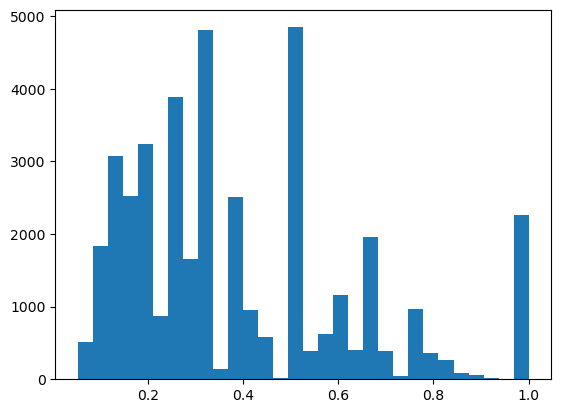

In [58]:
plt.hist(gtg_df_10['in_10_share'], bins = 30)
plt.show();

In [59]:
gtg_df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40444 entries, 0 to 40443
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   play_id               40444 non-null  float64
 1   week                  40444 non-null  int64  
 2   posteam               40444 non-null  object 
 3   defteam               40444 non-null  object 
 4   sp                    40444 non-null  float64
 5   desc                  40444 non-null  object 
 6   play_type             40444 non-null  object 
 7   td_player_id          13025 non-null  object 
 8   incomplete_pass       40444 non-null  float64
 9   rush_attempt          40444 non-null  float64
 10  pass_attempt          40444 non-null  float64
 11  touchdown             40444 non-null  float64
 12  pass_touchdown        40444 non-null  float64
 13  rush_touchdown        40444 non-null  float64
 14  complete_pass         40444 non-null  float64
 15  receiver_player_id 

In [60]:
gtg_df_10['player_id'].nunique()

2082

In [61]:
flex_merge['player_id'].nunique()

2323

In [62]:
##Maybe we need to pause here. There are more players in our weekly data than we have in our gtg data, which makes sense.
#Not every player will be used in gtg situations.
#Maybe somehow just check that every player in flex_merge but not gtg doesn't have any True values in goal_to_go
####Maybe we should just use common sense
#We've filtered every gtg play that was a run or a pass.
#If there's any irregularity it's likely to come out during spot-checking

In [63]:
gtg_players = list(gtg_df_10['player_id'].unique())

In [64]:
flex_players = list(flex_merge['player_id'].unique())

In [65]:
len(gtg_players)

2082

In [66]:
len(flex_players)

2323

In [67]:
#gtg_df = gtg_df.sort_values(by = ['season', 'week', 'posteam', 'defteam'])

In [68]:
gtg_df_10 = gtg_df_10.groupby(['season', 'week', 'posteam', 'defteam', 'player_id'], as_index=False).agg({'in_10_share': 'mean'})


In [69]:
#gtg_df = gtg_df[['season', 'week', 'posteam', 'defteam', 'player_id', 'gtg_share']]

In [70]:
gtg_df_10.tail(30)

,season,week,posteam,defteam,player_id,in_10_share
26207,2023,20,DET,TB,00-0036963,0.222
26208,2023,20,DET,TB,00-0039065,0.111
26209,2023,20,DET,TB,00-0039139,0.111
26210,2023,20,GB,SF,00-0033293,0.800
26211,2023,20,GB,SF,00-0038996,0.200
26212,2023,20,KC,BUF,00-0030506,0.400
26213,2023,20,KC,BUF,00-0035140,0.400
26214,2023,20,KC,BUF,00-0037197,0.200
26215,2023,20,SF,GB,00-0033280,1.000
26216,2023,20,TB,DET,00-0031408,0.500


In [71]:
check_for_one = gtg_df_10.groupby(['season', 'week', 'posteam', 'defteam'])['in_10_share'].sum()

In [72]:
check_for_one.min()

0.997

In [73]:
gtg_df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26237 entries, 0 to 26236
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   season       26237 non-null  int64  
 1   week         26237 non-null  int64  
 2   posteam      26237 non-null  object 
 3   defteam      26237 non-null  object 
 4   player_id    26237 non-null  object 
 5   in_10_share  26237 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 1.2+ MB


In [74]:
gtg_df_10.rename(columns = {'posteam': 'recent_team', 'defteam': 'opponent_team'}, inplace = True)

In [75]:
flex_merge = pd.merge(flex_merge, gtg_df_10, on = ['season', 'week', 'recent_team', 'opponent_team', 'player_id'], how = 'left')

In [76]:
flex_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   passing_yards                82260 non-null  float64
 8   passing_tds                  82260 non-null  int64  
 9   interceptions                82260 non-null  float64
 10  passing_2pt_conversions      82260 non-null  int64  
 11  rushing_yards                82260 non-null  float64
 12  rushing_tds                  82260 non-null  int64  
 13  rushing_fumbles_

# A lot of missing in_10_share variables
At first glance it seems like there are too many nulls in the in_10_share column, which is the percentage of plays inside the 10-yard-line that each player gets the ball. But maybe it is plausible. After all, in those goal-line situations only the best players are called upon. We'll replace with zero and investigate further when we examine the data.

In [77]:
flex_merge.fillna(value={'in_10_share': 0}, inplace=True)

Let's rename flex_merge flex_df so we can run the following code

In [78]:
flex_df = flex_merge

# Fantasy points
This is where we calculate FanDuel and DraftKings points.

In [79]:
flex_df['FD_Pts'] = (flex_df['passing_yards'] * 0.04) + (flex_df['rushing_tds'] * 6) + (flex_df['rushing_yards'] * 0.1)\
+ (flex_df['passing_tds'] * 4) + (flex_df['receiving_yards'] * 0.1) + (flex_df['receiving_tds'] * 6) + (flex_df['receptions'] * 0.5)\
+ (flex_df['rushing_2pt_conversions'] * 2) + (flex_df['passing_2pt_conversions'] * 2) + (flex_df['receiving_2pt_conversions'] * 2)\
+ (flex_df['special_teams_tds'] * 6) - (flex_df['interceptions']) - (flex_df['sack_fumbles_lost'] * 2) - (flex_df['receiving_fumbles_lost'] * 2)\
- (flex_df['rushing_fumbles_lost'] * 2)

In [80]:
flex_df['DK_Pts'] = (flex_df['passing_yards'] * 0.04) + (flex_df['rushing_tds'] * 6) + (flex_df['rushing_yards'] * 0.1)\
+ (flex_df['passing_tds'] * 4) + (flex_df['receiving_yards'] * 0.1) + (flex_df['receiving_tds'] * 6) + (flex_df['receptions'] * 1)\
+ (flex_df['rushing_2pt_conversions'] * 2) + (flex_df['passing_2pt_conversions'] * 2) + (flex_df['receiving_2pt_conversions'] * 2)\
+ (flex_df['special_teams_tds'] * 6) - (flex_df['interceptions']) - (flex_df['sack_fumbles_lost']) - (flex_df['receiving_fumbles_lost'])\
- (flex_df['rushing_fumbles_lost'])

Adding DraftKings bonus points

In [81]:
flex_df['DK_Pts'] = np.where(flex_df['passing_yards'] >= 300, flex_df['DK_Pts'] + 3, flex_df['DK_Pts'])
flex_df['DK_Pts'] = np.where(flex_df['receiving_yards'] >= 100, flex_df['DK_Pts'] + 3, flex_df['DK_Pts'])
flex_df['DK_Pts'] = np.where(flex_df['rushing_yards'] >= 100, flex_df['DK_Pts'] + 3, flex_df['DK_Pts'])

In [82]:
flex_df

,season,week,recent_team,opponent_team,player_id,player_display_name,position,passing_yards,passing_tds,interceptions,...,receiving_yards_after_catch,receiving_air_yards,air_yards_share,target_share,game_id,total_carries,carry_share,in_10_share,FD_Pts,DK_Pts
0,2006,1,ARI,SF,00-0008241,Edgerrin James,RB,0.0,0,0.0,...,15.0,-2.0,-0.013699,0.130435,2006_01_SF_ARI,29,0.897,0.556,16.10,17.60
1,2006,1,ARI,SF,00-0019552,Troy Walters,WR,0.0,0,0.0,...,7.0,8.0,0.054795,0.086957,2006_01_SF_ARI,29,0.000,0.111,8.50,9.50
2,2006,1,ARI,SF,00-0022084,Anquan Boldin,WR,0.0,0,0.0,...,48.0,14.0,0.095890,0.173913,2006_01_SF_ARI,29,0.000,0.111,14.20,16.20
3,2006,1,ARI,SF,00-0022156,Bryant Johnson,WR,0.0,0,0.0,...,33.0,18.0,0.123288,0.086957,2006_01_SF_ARI,29,0.000,0.000,6.10,7.10
4,2006,1,ARI,SF,00-0022921,Larry Fitzgerald,WR,0.0,0,0.0,...,27.0,106.0,0.726027,0.391304,2006_01_SF_ARI,29,0.000,0.000,17.80,25.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82255,2023,22,SF,KC,00-0034407,Ray-Ray McCloud,WR,0.0,0,0.0,...,0.0,19.0,0.061889,0.027027,2023_22_SF_KC,30,0.000,0.000,2.40,2.90
82256,2023,22,SF,KC,00-0035719,Deebo Samuel,WR,0.0,0,0.0,...,26.0,123.0,0.400651,0.297297,2023_22_SF_KC,30,0.100,0.000,5.60,7.10
82257,2023,22,SF,KC,00-0036259,Jauan Jennings,WR,21.0,1,0.0,...,23.0,19.0,0.061889,0.135135,2023_22_SF_KC,30,0.000,0.500,17.04,19.04
82258,2023,22,SF,KC,00-0036261,Brandon Aiyuk,WR,0.0,0,0.0,...,14.0,88.0,0.286645,0.162162,2023_22_SF_KC,30,0.000,0.000,6.40,7.90


We can see the two different Adrian Petersons with different player_ids

In [83]:
flex_df[flex_df['player_display_name'] == 'Adrian Peterson'][['player_id', 'player_display_name', 'recent_team', 'FD_Pts', 'DK_Pts']]

,player_id,player_display_name,recent_team,FD_Pts,DK_Pts
265,00-0021306,Adrian Peterson,CHI,0.1,0.1
1523,00-0021306,Adrian Peterson,CHI,2.3,2.8
2176,00-0021306,Adrian Peterson,CHI,0.9,1.4
2925,00-0021306,Adrian Peterson,CHI,10.9,11.4
3175,00-0021306,Adrian Peterson,CHI,1.3,1.3
...,...,...,...,...,...
67085,00-0025394,Adrian Peterson,DET,12.3,12.3
69868,00-0025394,Adrian Peterson,TEN,9.1,9.6
70103,00-0025394,Adrian Peterson,TEN,2.5,3.0
70381,00-0025394,Adrian Peterson,TEN,5.4,6.4


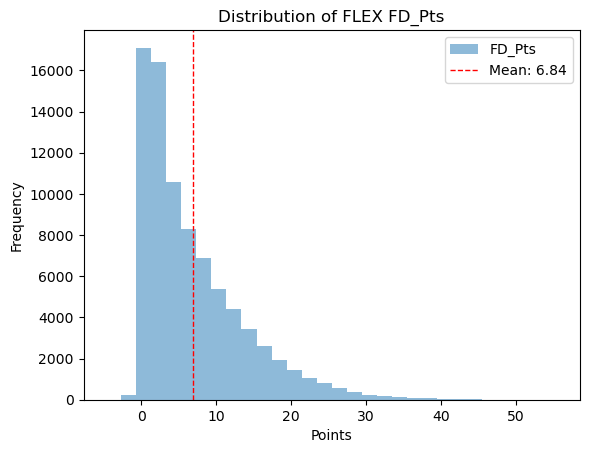

In [84]:
# Plot FD_Pts
plt.hist(flex_df['FD_Pts'], bins=30, alpha=0.5, label='FD_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df['FD_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of FLEX FD_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

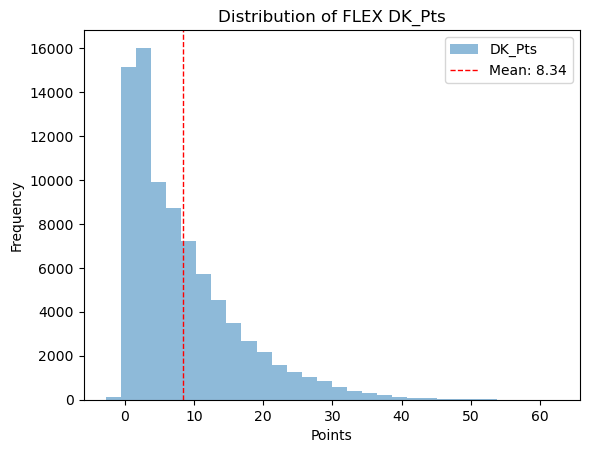

In [85]:
# Plot DK_Pts
plt.hist(flex_df['DK_Pts'], bins=30, alpha=0.5, label='DK_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df['DK_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of FLEX DK_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

# Spike near zero
That concentration of players with zero or near-zero fantasy points gives us hope that at least most of the players are included in this weekly data. When we did our QB data wrangling, this is the point where we derived DvP variables. We combined all QB points by each team in each game, so that backups and starters were added together. But we'll hold off on that for now because we still don't know if we have accounted for every player who has scored fantasy points against an opponent.<br>

What we will do right now is break down this scoring by position.

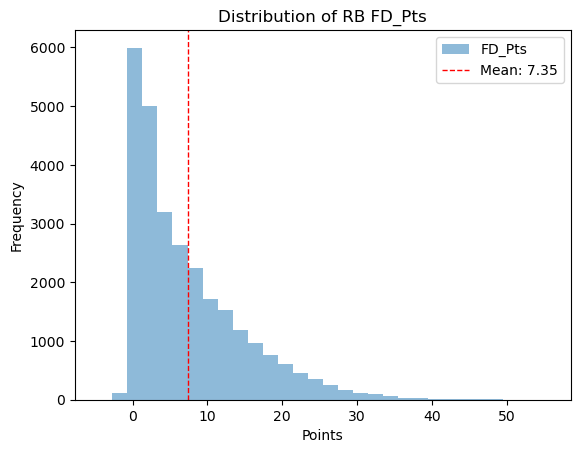

In [86]:
# Plot FD_Pts
plt.hist(flex_df[flex_df['position'].isin(['RB', 'HB', 'FB'])]['FD_Pts'], bins=30, alpha=0.5, label='FD_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'].isin(['RB', 'HB', 'FB'])]['FD_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of RB FD_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

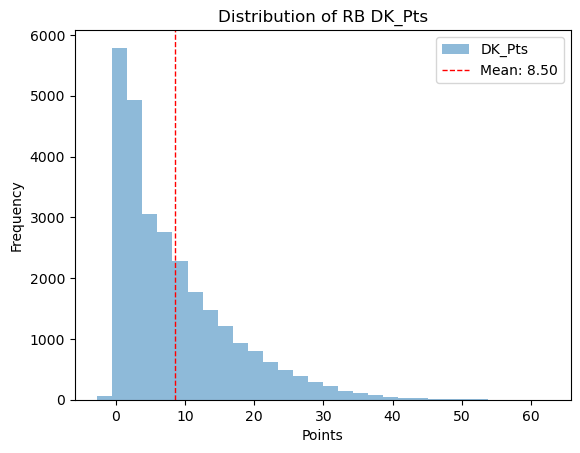

In [87]:
# Plot DK_Pts
plt.hist(flex_df[flex_df['position'].isin(['RB', 'HB', 'FB'])]['DK_Pts'], bins=30, alpha=0.5, label='DK_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'].isin(['RB', 'HB', 'FB'])]['DK_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of RB DK_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

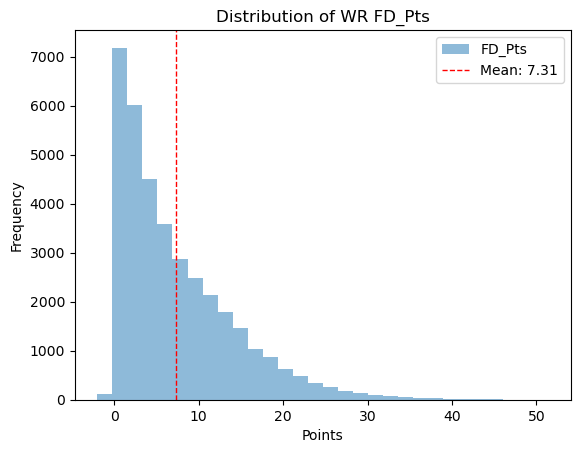

In [88]:
# Plot FD_Pts
plt.hist(flex_df[flex_df['position'] == 'WR']['FD_Pts'], bins=30, alpha=0.5, label='FD_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'] == 'WR']['FD_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of WR FD_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

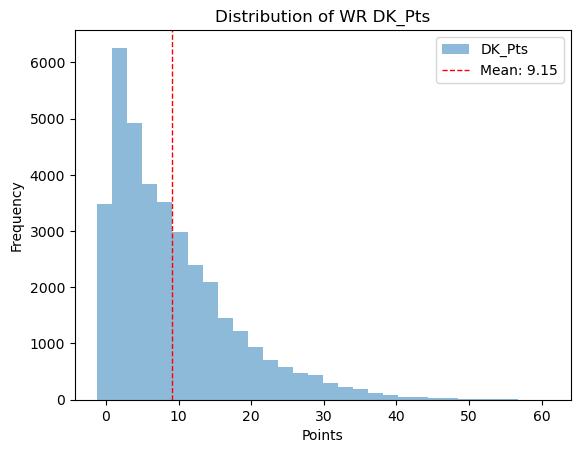

In [89]:
# Plot DK_Pts
plt.hist(flex_df[flex_df['position'] == 'WR']['DK_Pts'], bins=30, alpha=0.5, label='DK_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'] == 'WR']['DK_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of WR DK_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

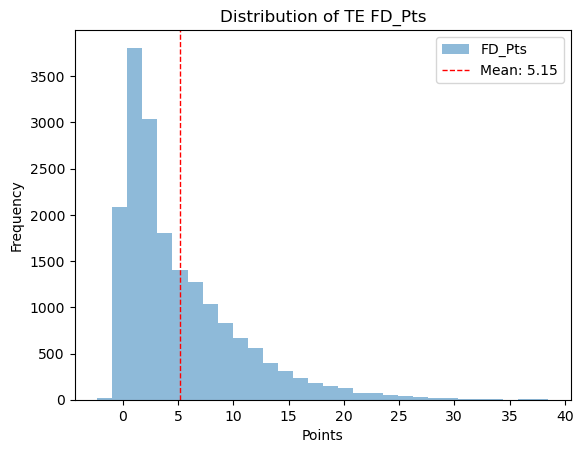

In [90]:
# Plot FD Pts
plt.hist(flex_df[flex_df['position'] == 'TE']['FD_Pts'], bins=30, alpha=0.5, label='FD_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'] == 'TE']['FD_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of TE FD_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

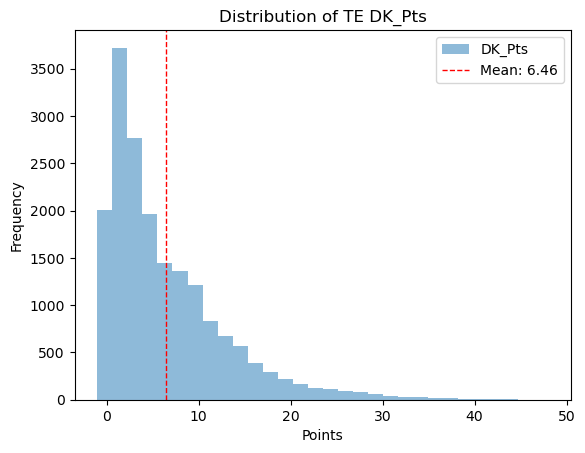

In [91]:
# Plot DK Pts
plt.hist(flex_df[flex_df['position'] == 'TE']['DK_Pts'], bins=30, alpha=0.5, label='DK_Pts')

# Calculate the mean of FD_Pts
mean_pts = flex_df[flex_df['position'] == 'TE']['DK_Pts'].mean()

# Add a vertical line for the mean
plt.axvline(mean_pts, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_pts:.2f}')

# Adding titles and labels
plt.title('Distribution of TE DK_Pts')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [92]:
flex_df['position'] = np.where(flex_df['position'].isin(['HB', 'FB']), 'RB', flex_df['position'])

In [93]:
pos_mean_by_team = flex_df.groupby(['season', 'week', 'recent_team', 'opponent_team', 'position']).size().reset_index(name = 'num_players')

In [94]:
mean_by_pos = pos_mean_by_team.groupby('position')['num_players'].agg(['mean', 'max', 'min'])

In [95]:
mean_by_pos

,mean,max,min
position,,,
RB,2.836556,6,1
TE,1.906974,4,1
WR,3.745937,7,1


In [96]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   passing_yards                82260 non-null  float64
 8   passing_tds                  82260 non-null  int64  
 9   interceptions                82260 non-null  float64
 10  passing_2pt_conversions      82260 non-null  int64  
 11  rushing_yards                82260 non-null  float64
 12  rushing_tds                  82260 non-null  int64  
 13  rushing_fumbles_

# Grouping points allowed by position
First step in deriving DvP variables.

In [97]:
grouped_pts = flex_df.groupby(['season', 'week', 'recent_team', 'opponent_team', 'position'])[['DK_Pts', 'FD_Pts']].sum().round(3)

In [98]:
grouped_pts

DK_Pts  FD_Pts
season week recent_team opponent_team position                
2006   1    ARI         SF            RB         18.70   17.20
                                      TE         11.70   10.20
                                      WR         58.10   46.60
            ATL         CAR           RB         28.00   24.00
                                      TE         11.70   10.20
...                                                ...     ...
2023   22   KC          SF            TE         22.50   17.00
                                      WR         44.50   37.00
            SF          KC            RB         35.10   29.10
                                      TE          2.40    1.40
                                      WR         39.74   33.74

[29022 rows x 2 columns]

In [99]:
grouped_pts.reset_index(inplace = True)

In [100]:
grouped_pts = grouped_pts.sort_values(by = ['opponent_team', 'season', 'week'])
#grouped_pts['opp_game_num'] = grouped_pts.groupby(['opponent_team', 'season', 'week', 'recent_team']).cumcount() + 1
grouped_pts.reset_index(inplace = True)

In [101]:
grouped_pts_raw = grouped_pts.copy()

In [102]:
grouped_pts.drop(columns = ['index'], inplace = True)

In [103]:
grouped_pts

,season,week,recent_team,opponent_team,position,DK_Pts,FD_Pts
0,2006,1,SF,ARI,RB,38.4,32.9
1,2006,1,SF,ARI,TE,14.9,10.9
2,2006,1,SF,ARI,WR,28.2,21.2
3,2006,2,SEA,ARI,RB,32.0,31.0
4,2006,2,SEA,ARI,WR,37.9,29.9
...,...,...,...,...,...,...,...
29017,2023,17,SF,WAS,TE,5.9,4.4
29018,2023,17,SF,WAS,WR,45.6,36.6
29019,2023,18,DAL,WAS,RB,29.6,27.1
29020,2023,18,DAL,WAS,TE,16.3,12.8


In [104]:
# Create the pivot table
pivot_df = grouped_pts.pivot_table(
    index=['season', 'week', 'recent_team', 'opponent_team'],
    columns='position',
    values=['DK_Pts', 'FD_Pts'],
    aggfunc='sum',  # Assuming you want to sum the points if there are duplicates
    fill_value=0  # Fill missing values with 0
)

In [105]:
# Flatten the MultiIndex columns created by pivot_table
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]

In [106]:
# Reset the index to turn the pivot table back into a DataFrame
pivot_df.reset_index(inplace=True)

In [107]:
pivot_df.head()

,season,week,recent_team,opponent_team,DK_Pts_RB,DK_Pts_TE,DK_Pts_WR,FD_Pts_RB,FD_Pts_TE,FD_Pts_WR
0,2006,1,ARI,SF,18.7,11.7,58.1,17.2,10.2,46.6
1,2006,1,ATL,CAR,28.0,11.7,19.7,24.0,10.2,17.2
2,2006,1,BAL,TB,19.5,23.8,13.9,18.5,19.8,10.4
3,2006,1,BUF,NE,23.9,2.4,21.0,21.9,1.9,16.0
4,2006,1,CAR,ATL,14.2,5.4,26.5,11.2,3.9,20.5


In [108]:
pivot_df = pivot_df.sort_values(by = ['opponent_team', 'season', 'week'])

In [109]:
pivot_df['opp_game_num'] = pivot_df.groupby(['opponent_team']).cumcount() + 1

In [110]:
cols_for_dvp = ['DK_Pts_RB', 'DK_Pts_TE', 'DK_Pts_WR', 'FD_Pts_RB', 'FD_Pts_TE', 'FD_Pts_WR']

In [111]:
pivot_df_by_game = pivot_df.copy()

# DvP variables
We'll take an 8-game rolling mean for fantasy points allowed to RBs, WRs and TEs for each team, even if the games go back to last season. DvP means defense vs. position.

In [112]:
def calculate_equal_rolling_mean(group, cols, suffix):
    """
    This function calculates a rolling mean for the last eight games, going back to previous season if necessary.
    It also calculates when there are less than eight games to use.
    """
    for col in cols:
        group[f'{col}{suffix}'] = (
            group[col].shift().rolling(window=8, min_periods=1).mean()
        )
    return group

In [113]:
pivot_df = pivot_df.groupby('opponent_team', as_index = False).apply(calculate_equal_rolling_mean, cols=cols_for_dvp, suffix = '_DvP')

In [114]:
pivot_df.drop(columns = cols_for_dvp + ['opp_game_num'], inplace = True)

In [115]:
pivot_df

season  week recent_team opponent_team  DK_Pts_RB_DvP  DK_Pts_TE_DvP  \
0  28      2006     1          SF           ARI            NaN            NaN   
   59      2006     2         SEA           ARI      38.400000      14.900000   
   78      2006     3          LA           ARI      35.200000       7.450000   
   93      2006     4         ATL           ARI      29.966667       5.833333   
   132     2006     5          KC           ARI      29.450000       5.625000   
...         ...   ...         ...           ...            ...            ...   
31 9527    2023    13         MIA           WAS      24.587500      14.237500   
   9584    2023    15          LA           WAS      27.975000      12.500000   
   9624    2023    16         NYJ           WAS      29.400000      10.025000   
   9660    2023    17          SF           WAS      32.612500       8.125000   
   9672    2023    18         DAL           WAS      33.900000       7.912500   

         DK_Pts_WR_DvP  FD_Pts_RB_DvP  FD_Pts_TE_DvP  FD_Pts_WR_DvP  
0  28              NaN            NaN            NaN            NaN  
   59        28.200000        32.9000      10.900000        21.2000  
   78        33.050000        31.9500       5.450000        25.5500  
   93        36.766667        26.8000       4.333333        28.1000  
   132       32.700000        26.0750       4.250000        25.0750  
...                ...            ...            ...            ...  
31 9527      42.687500        21.7750      11.675000        35.1250  
   9584      42.325000        24.8500      10.250000        34.5125  
   9624      44.837500        25.7125       8.025000        36.9000  
   9660      45.562500        28.5500       6.312500        37.3750  
   9672      42.737500        30.0250       6.162500        34.8625  

[9722 rows x 10 columns]

In [116]:
pivot_df.loc[1, :].head(20)

,season,week,recent_team,opponent_team,DK_Pts_RB_DvP,DK_Pts_TE_DvP,DK_Pts_WR_DvP,FD_Pts_RB_DvP,FD_Pts_TE_DvP,FD_Pts_WR_DvP
4,2006,1,CAR,ATL,NaN,NaN,NaN,NaN,NaN,NaN
61,2006,2,TB,ATL,14.200000,5.400000,26.500000,11.200000,3.900000,20.500000
82,2006,3,NO,ATL,13.300000,4.200000,38.550000,10.300000,2.950000,29.050000
92,2006,4,ARI,ATL,17.066667,2.800000,37.366667,13.733333,1.966667,29.033333
165,2006,6,NYG,ATL,15.800000,3.750000,32.900000,12.675000,2.750000,25.650000
196,2006,7,PIT,ATL,20.960000,7.700000,29.680000,17.460000,6.300000,23.180000
205,2006,8,CIN,ATL,18.450000,8.333333,39.333333,15.283333,6.916667,31.750000
236,2006,9,DET,ATL,18.385714,7.814286,41.214286,15.385714,6.385714,33.500000
263,2006,10,CLE,ATL,20.212500,8.600000,41.062500,16.962500,6.975000,33.312500
290,2006,11,BAL,ATL,19.762500,10.475000,40.100000,16.762500,8.475000,32.662500


In [117]:
flex_df = pd.merge(flex_df, pivot_df, on = ['season', 'week', 'recent_team', 'opponent_team'], how = 'left')

In [118]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   passing_yards                82260 non-null  float64
 8   passing_tds                  82260 non-null  int64  
 9   interceptions                82260 non-null  float64
 10  passing_2pt_conversions      82260 non-null  int64  
 11  rushing_yards                82260 non-null  float64
 12  rushing_tds                  82260 non-null  int64  
 13  rushing_fumbles_

In [119]:
flex_df.reset_index(inplace = True)

In [120]:
flex_df.columns

Index(['index', 'season', 'week', 'recent_team', 'opponent_team', 'player_id',
       'player_display_name', 'position', 'passing_yards', 'passing_tds',
       'interceptions', 'passing_2pt_conversions', 'rushing_yards',
       'rushing_tds', 'rushing_fumbles_lost', 'rushing_2pt_conversions',
       'receptions', 'receiving_yards', 'receiving_tds',
       'receiving_fumbles_lost', 'receiving_2pt_conversions',
       'sack_fumbles_lost', 'special_teams_tds', 'targets', 'carries',
       'receiving_yards_after_catch', 'receiving_air_yards', 'air_yards_share',
       'target_share', 'game_id', 'total_carries', 'carry_share',
       'in_10_share', 'FD_Pts', 'DK_Pts', 'DK_Pts_RB_DvP', 'DK_Pts_TE_DvP',
       'DK_Pts_WR_DvP', 'FD_Pts_RB_DvP', 'FD_Pts_TE_DvP', 'FD_Pts_WR_DvP'],
      dtype='object')

# Paring down some of the columns
We're drop columns that won't be needed for features.

In [121]:
cols_to_keep = ['season', 'week', 'recent_team', 'opponent_team', 'player_id',
       'player_display_name', 'position', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 
       'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'targets', 'carries',
       'receiving_yards_after_catch', 'receiving_air_yards', 'air_yards_share',
       'target_share', 'carry_share','in_10_share', 'FD_Pts', 'DK_Pts', 'DK_Pts_RB_DvP', 'DK_Pts_TE_DvP',
       'DK_Pts_WR_DvP', 'FD_Pts_RB_DvP', 'FD_Pts_TE_DvP', 'FD_Pts_WR_DvP']

In [122]:
flex_df = flex_df[cols_to_keep]

In [123]:
#quarterback_df[quarterback_df['season'] >= 2006]['passing_air_yards']

In [124]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   rushing_yards                82260 non-null  float64
 8   rushing_tds                  82260 non-null  int64  
 9   rushing_fumbles_lost         82260 non-null  float64
 10  receptions                   82260 non-null  int64  
 11  receiving_yards              82260 non-null  float64
 12  receiving_tds                82260 non-null  int64  
 13  receiving_fumble

# Filling missing values
We have found that dropping rows with missing values can affect calculations down the line. So we need to find ways to fill the missing values.<br>

The first row of every team grouping when we calculated DvP was NaN because there was no previous value. We'll fill those in with the mean.

In [125]:
flex_df['FD_Pts_RB_DvP'] = flex_df['FD_Pts_RB_DvP'].fillna(flex_df['FD_Pts_RB_DvP'].mean())
flex_df['DK_Pts_RB_DvP'] = flex_df['DK_Pts_RB_DvP'].fillna(flex_df['DK_Pts_RB_DvP'].mean())
flex_df['FD_Pts_TE_DvP'] = flex_df['FD_Pts_TE_DvP'].fillna(flex_df['FD_Pts_TE_DvP'].mean())
flex_df['DK_Pts_TE_DvP'] = flex_df['DK_Pts_TE_DvP'].fillna(flex_df['DK_Pts_TE_DvP'].mean())
flex_df['FD_Pts_WR_DvP'] = flex_df['FD_Pts_WR_DvP'].fillna(flex_df['FD_Pts_WR_DvP'].mean())
flex_df['DK_Pts_WR_DvP'] = flex_df['DK_Pts_WR_DvP'].fillna(flex_df['DK_Pts_WR_DvP'].mean())

In [126]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   season                       82260 non-null  int64  
 1   week                         82260 non-null  int64  
 2   recent_team                  82260 non-null  object 
 3   opponent_team                82260 non-null  object 
 4   player_id                    82260 non-null  object 
 5   player_display_name          82260 non-null  object 
 6   position                     82260 non-null  object 
 7   rushing_yards                82260 non-null  float64
 8   rushing_tds                  82260 non-null  int64  
 9   rushing_fumbles_lost         82260 non-null  float64
 10  receptions                   82260 non-null  int64  
 11  receiving_yards              82260 non-null  float64
 12  receiving_tds                82260 non-null  int64  
 13  receiving_fumble

In [127]:
cols_L8 = ['rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'receptions', 'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'targets',\
           'carries', 'receiving_yards_after_catch', 'receiving_air_yards', 'air_yards_share', 'target_share', 'carry_share', 'in_10_share']

In [128]:
flex_L8_features = flex_df.groupby(['player_id', 'player_display_name', 'season', 'week'])[cols_L8].sum()

In [129]:
flex_L8_features

rushing_yards  rushing_tds  \
player_id  player_display_name season week                               
00-0000166 Stephen Alexander   2006   1               0.0            0   
                                      2               0.0            0   
                                      3               0.0            0   
                                      10              0.0            0   
                                      11              0.0            0   
...                                                   ...          ...   
00-0039165 Zach Charbonnet     2023   14             44.0            0   
                                      15             16.0            0   
                                      16              0.0            0   
                                      17              2.0            0   
                                      18             32.0            0   

                                            rushing_fumbles_lost  receptions  \
player_id  player_display_name season week                                     
00-0000166 Stephen Alexander   2006   1                      0.0           2   
                                      2                      0.0           2   
                                      3                      0.0           1   
                                      10                     0.0           6   
                                      11                     0.0           1   
...                                                          ...         ...   
00-0039165 Zach Charbonnet     2023   14                     0.0           1   
                                      15                     0.0           0   
                                      16                     0.0           1   
                                      17                     0.0           5   
                                      18                     0.0           2   

                                            receiving_yards  receiving_tds  \
player_id  player_display_name season week                                   
00-0000166 Stephen Alexander   2006   1                24.0              0   
                                      2                 8.0              0   
                                      3                24.0              0   
                                      10               49.0              0   
                                      11                4.0              0   
...                                                     ...            ...   
00-0039165 Zach Charbonnet     2023   14                4.0              0   
                                      15                0.0              0   
                                      16               -4.0              0   
                                      17               39.0              0   
                                      18               28.0              0   

                                            receiving_fumbles_lost  targets  \
player_id  player_display_name season week                                    
00-0000166 Stephen Alexander   2006   1                        0.0        2   
                                      2                        0.0        2   
                                      3                        0.0        1   
                                      10                       0.0        6   
                                      11                       0.0        1   
...                                                            ...      ...   
00-0039165 Zach Charbonnet     2023   14                       0.0        1   
                                      15                       0.0        1   
                                      16                       0.0        2   
                                      17                       0.0        5   
                                      18                       0.0        2  

# L8 variables
L8 variables are rolling means of features over the last eight games. Just like we did for the DvP variables, we'll calculate features over the previous eight games for individual QBs.

In [130]:
flex_L8_features = flex_L8_features.sort_values(by = ['player_id', 'season', 'week'])
flex_L8_features['game_num'] = flex_L8_features.groupby(['player_id', 'season']).cumcount() + 1
#quarterback_df.reset_index(drop = True, inplace = True)

In [131]:
flex_L8_features = flex_L8_features.groupby(['player_id', 'player_display_name'], as_index = False).apply(calculate_equal_rolling_mean, cols=cols_L8, suffix = '_L8')

In [132]:
flex_L8_features.reset_index(inplace = True)

In [133]:
flex_L8_features.columns

Index(['level_0', 'player_id', 'player_display_name', 'season', 'week',
       'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'receptions',
       'receiving_yards', 'receiving_tds', 'receiving_fumbles_lost', 'targets',
       'carries', 'receiving_yards_after_catch', 'receiving_air_yards',
       'air_yards_share', 'target_share', 'carry_share', 'in_10_share',
       'game_num', 'rushing_yards_L8', 'rushing_tds_L8',
       'rushing_fumbles_lost_L8', 'receptions_L8', 'receiving_yards_L8',
       'receiving_tds_L8', 'receiving_fumbles_lost_L8', 'targets_L8',
       'carries_L8', 'receiving_yards_after_catch_L8',
       'receiving_air_yards_L8', 'air_yards_share_L8', 'target_share_L8',
       'carry_share_L8', 'in_10_share_L8'],
      dtype='object')

In [134]:
flex_L8_features.drop(columns = ['level_0', 'rushing_yards', 'rushing_tds', 'rushing_fumbles_lost', 'receptions', 'receiving_yards',
       'receiving_tds', 'receiving_fumbles_lost', 'targets', 'carries', 'receiving_yards_after_catch', 'receiving_air_yards', 'air_yards_share',
       'target_share', 'carry_share', 'in_10_share'], inplace = True)

In [135]:
flex_L8_features

,player_id,player_display_name,season,week,game_num,rushing_yards_L8,rushing_tds_L8,rushing_fumbles_lost_L8,receptions_L8,receiving_yards_L8,receiving_tds_L8,receiving_fumbles_lost_L8,targets_L8,carries_L8,receiving_yards_after_catch_L8,receiving_air_yards_L8,air_yards_share_L8,target_share_L8,carry_share_L8,in_10_share_L8
0,00-0000166,Stephen Alexander,2006,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-0000166,Stephen Alexander,2006,2,2,0.000,0.000,0.0,2.000000,24.000000,0.0,0.0,2.000000,0.000,19.000,5.000000,0.063291,0.153846,0.000000,0.000000
2,00-0000166,Stephen Alexander,2006,3,3,0.000,0.000,0.0,2.000000,16.000000,0.0,0.0,2.000000,0.000,13.500,2.500000,0.031646,0.139423,0.000000,0.000000
3,00-0000166,Stephen Alexander,2006,10,4,0.000,0.000,0.0,1.666667,18.666667,0.0,0.0,1.666667,0.000,13.000,5.666667,0.053617,0.115171,0.000000,0.000000
4,00-0000166,Stephen Alexander,2006,11,5,0.000,0.000,0.0,2.750000,26.250000,0.0,0.0,2.750000,0.000,15.250,11.000000,0.095091,0.161378,0.000000,0.050000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82255,00-0039165,Zach Charbonnet,2023,14,12,36.875,0.125,0.0,2.625000,16.125000,0.0,0.0,3.125000,8.750,21.125,-5.125000,-0.024126,0.092840,0.425875,0.225750
82256,00-0039165,Zach Charbonnet,2023,15,13,38.500,0.125,0.0,2.625000,15.500000,0.0,0.0,2.875000,9.250,20.625,-4.125000,-0.013646,0.082449,0.455000,0.225750
82257,00-0039165,Zach Charbonnet,2023,16,14,39.875,0.125,0.0,2.375000,13.750000,0.0,0.0,2.750000,9.500,18.750,-3.625000,-0.011701,0.079598,0.466750,0.225750
82258,00-0039165,Zach Charbonnet,2023,17,15,33.250,0.125,0.0,2.250000,11.875000,0.0,0.0,2.750000,9.125,17.125,-4.750000,-0.016914,0.079598,0.440250,0.267375


In [136]:
flex_df = pd.merge(flex_df, flex_L8_features, on = ['player_id', 'player_display_name', 'season', 'week'], how = 'left')

In [137]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82260 non-null  int64  
 1   week                            82260 non-null  int64  
 2   recent_team                     82260 non-null  object 
 3   opponent_team                   82260 non-null  object 
 4   player_id                       82260 non-null  object 
 5   player_display_name             82260 non-null  object 
 6   position                        82260 non-null  object 
 7   rushing_yards                   82260 non-null  float64
 8   rushing_tds                     82260 non-null  int64  
 9   rushing_fumbles_lost            82260 non-null  float64
 10  receptions                      82260 non-null  int64  
 11  receiving_yards                 82260 non-null  float64
 12  receiving_tds                   

# Filling missing values with mean
In our QB model we made the mistake of dropping missing values at this point. Rookies making their debut won't have L8 variables because they haven't played before. So let's fill those values with the means.

In [138]:
cols_to_fill = ['rushing_yards_L8', 'rushing_tds_L8', 'rushing_fumbles_lost_L8', 'receptions_L8',
       'receiving_yards_L8', 'receiving_tds_L8', 'receiving_fumbles_lost_L8',
       'targets_L8', 'carries_L8', 'receiving_yards_after_catch_L8',
       'receiving_air_yards_L8', 'air_yards_share_L8', 'target_share_L8',
       'carry_share_L8', 'in_10_share_L8']

In [139]:
for col in cols_to_fill:
    flex_df[col] = flex_df[col].fillna(flex_df[col].mean())

In [140]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82260 non-null  int64  
 1   week                            82260 non-null  int64  
 2   recent_team                     82260 non-null  object 
 3   opponent_team                   82260 non-null  object 
 4   player_id                       82260 non-null  object 
 5   player_display_name             82260 non-null  object 
 6   position                        82260 non-null  object 
 7   rushing_yards                   82260 non-null  float64
 8   rushing_tds                     82260 non-null  int64  
 9   rushing_fumbles_lost            82260 non-null  float64
 10  receptions                      82260 non-null  int64  
 11  receiving_yards                 82260 non-null  float64
 12  receiving_tds                   

# A few more features
yards_per_carry, yards_per_reception, yards_per_target

In [141]:
flex_df['yards_per_carry_L8'] = flex_df['rushing_yards_L8']/flex_df['carries_L8']
flex_df['yards_per_reception_L8'] = flex_df['receiving_yards_L8']/flex_df['receptions_L8']
flex_df['yards_per_target_L8'] = flex_df['receiving_yards_L8']/flex_df['targets_L8']

# More missing
Now this gives us some more missing values. In most cases, it's because we've tried to divide by zero when a player has averaged 0 carries over the last eight games. So here we should fill the missing values with 0

In [142]:
flex_df.fillna(0, inplace = True)

In [143]:
flex_df_full = flex_df.copy()

In [144]:
flex_df.drop(columns = cols_L8, inplace = True)

# Wind speed and division games
From the play-by-play data we're going to bring in variables that look at wind speed and whether or not the game is a division game. Defenses could be more familiar with division opponents so that could limit fantasy performance.

In [145]:
wind_div_cols = ['play_id', 'game_id', 'home_team', 'away_team', 'season', 'week', 'posteam', 'posteam_type', 'defteam', 'play_type',\
                 'wind', 'weather', 'div_game', 'roof']	

In [146]:
#This will need to be made into a database table AFTER we correct for indoor games.
pbp_wind_div = nfl.import_pbp_data(seasons[6:], wind_div_cols)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


In [147]:
pbp_wind_div.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857073 entries, 0 to 857072
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   play_id                 857073 non-null  float32
 1   game_id                 857073 non-null  object 
 2   home_team               857073 non-null  object 
 3   away_team               857073 non-null  object 
 4   week                    857073 non-null  int32  
 5   posteam                 812692 non-null  object 
 6   posteam_type            812692 non-null  object 
 7   defteam                 812692 non-null  object 
 8   play_type               831645 non-null  object 
 9   wind                    595582 non-null  float32
 10  weather                 852369 non-null  object 
 11  div_game                857073 non-null  int32  
 12  roof                    857073 non-null  object 
 13  old_game_id             857073 non-null  object 
 14  season              

In [148]:
wind_div = pbp_wind_div.groupby(['season', 'week', 'game_id', 'posteam', 'defteam'])[['wind', 'div_game']].first().reset_index()

In [149]:
wind_div.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9722 entries, 0 to 9721
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   season    9722 non-null   int32  
 1   week      9722 non-null   int32  
 2   game_id   9722 non-null   object 
 3   posteam   9722 non-null   object 
 4   defteam   9722 non-null   object 
 5   wind      6760 non-null   float32
 6   div_game  9722 non-null   int32  
dtypes: float32(1), int32(3), object(3)
memory usage: 379.9+ KB


# Missing wind values
For now, we'll fill in missing wind values with the mean. More on this later.

In [150]:
wind_div['wind'] = wind_div['wind'].fillna(wind_div['wind'].mean())

In [151]:
wind_div.rename(columns = {'posteam': 'recent_team', 'defteam': 'opponent_team'}, inplace = True)

We basically need NLP to derive a rain factor for each game. We just can't quite do that at this point.

In [152]:
flex_df = pd.merge(flex_df, wind_div, on = ['season', 'week', 'recent_team', 'opponent_team'], how = 'left')

In [153]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82260 non-null  int64  
 1   week                            82260 non-null  int64  
 2   recent_team                     82260 non-null  object 
 3   opponent_team                   82260 non-null  object 
 4   player_id                       82260 non-null  object 
 5   player_display_name             82260 non-null  object 
 6   position                        82260 non-null  object 
 7   FD_Pts                          82260 non-null  float64
 8   DK_Pts                          82260 non-null  float64
 9   DK_Pts_RB_DvP                   82260 non-null  float64
 10  DK_Pts_TE_DvP                   82260 non-null  float64
 11  DK_Pts_WR_DvP                   82260 non-null  float64
 12  FD_Pts_RB_DvP                   

Dropping rows with missing values again

In [154]:
# for col in ['comp_pct', 'yds_per_attempt', 'td_pct', 'sack_pct', 'int_pct']:
#     quarterback_df[col] = quarterback_df[col].fillna(quarterback_df[col].mean())

In [155]:
#quarterback_df['wind'] = quarterback_df['wind'].fillna(0)

# The Jacksonville problem
The reason we're missing a div_game value for some rows is that there are a few rows where posteam == defteam. In most cases it's JAX. That's a mistake. We'll have to filter out those rows and we'll see that this eliminates missing div_game values.

In [156]:
flex_df[(flex_df['recent_team'] == flex_df['opponent_team'])]

,season,week,recent_team,opponent_team,player_id,player_display_name,position,FD_Pts,DK_Pts,DK_Pts_RB_DvP,...,air_yards_share_L8,target_share_L8,carry_share_L8,in_10_share_L8,yards_per_carry_L8,yards_per_reception_L8,yards_per_target_L8,game_id,wind,div_game


<!-- # Bringing in point spreads and totals
Pulling this dataframe from our database. It also includes binary variables for indoors and grass. -->

In [157]:
# # Connect to the SQLite database
# conn = sqlite3.connect('nfl_dfs.db')

# # Query specific columns from the table
# query1 = "SELECT * FROM spreads_totals"
# spread_df = pd.read_sql_query(query1, conn)

# # Close the connection
# conn.close()

In [158]:
flex_df.columns

Index(['season', 'week', 'recent_team', 'opponent_team', 'player_id',
       'player_display_name', 'position', 'FD_Pts', 'DK_Pts', 'DK_Pts_RB_DvP',
       'DK_Pts_TE_DvP', 'DK_Pts_WR_DvP', 'FD_Pts_RB_DvP', 'FD_Pts_TE_DvP',
       'FD_Pts_WR_DvP', 'game_num', 'rushing_yards_L8', 'rushing_tds_L8',
       'rushing_fumbles_lost_L8', 'receptions_L8', 'receiving_yards_L8',
       'receiving_tds_L8', 'receiving_fumbles_lost_L8', 'targets_L8',
       'carries_L8', 'receiving_yards_after_catch_L8',
       'receiving_air_yards_L8', 'air_yards_share_L8', 'target_share_L8',
       'carry_share_L8', 'in_10_share_L8', 'yards_per_carry_L8',
       'yards_per_reception_L8', 'yards_per_target_L8', 'game_id', 'wind',
       'div_game'],
      dtype='object')

In [159]:
#quarterback_df.drop(columns = ['defteam', 'passing_air_yards'], inplace = True)

In [160]:
flex_df.rename(columns = {'recent_team': 'team'}, inplace = True)

In [161]:
spread_df.head()

,season,week,game_id,team,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
0,2006,1,2006_01_ATL_CAR,ATL,CAR,-4.5,39.0,1,1,0,17.25,21.75
1,2006,1,2006_01_ATL_CAR,CAR,ATL,4.5,39.0,1,1,1,21.75,17.25
2,2006,1,2006_01_BAL_TB,BAL,TB,-3.0,33.0,1,1,0,15.00,18.00
3,2006,1,2006_01_BAL_TB,TB,BAL,3.0,33.0,1,1,1,18.00,15.00
4,2006,1,2006_01_BUF_NE,BUF,NE,-10.0,41.0,1,1,0,15.50,25.50


In [162]:
flex_df = pd.merge(flex_df, spread_df, on = ['season', 'week', 'team'], how = 'left')

In [163]:
flex_df.head()

,season,week,team,opponent_team,player_id,player_display_name,position,FD_Pts,DK_Pts,DK_Pts_RB_DvP,...,div_game,game_id_y,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total
0,2006,1,ARI,SF,00-0008241,Edgerrin James,RB,16.1,17.6,24.122535,...,1,2006_01_SF_ARI,SF,9.5,44.0,0,1,1,26.75,17.25
1,2006,1,ARI,SF,00-0019552,Troy Walters,WR,8.5,9.5,24.122535,...,1,2006_01_SF_ARI,SF,9.5,44.0,0,1,1,26.75,17.25
2,2006,1,ARI,SF,00-0022084,Anquan Boldin,WR,14.2,16.2,24.122535,...,1,2006_01_SF_ARI,SF,9.5,44.0,0,1,1,26.75,17.25
3,2006,1,ARI,SF,00-0022156,Bryant Johnson,WR,6.1,7.1,24.122535,...,1,2006_01_SF_ARI,SF,9.5,44.0,0,1,1,26.75,17.25
4,2006,1,ARI,SF,00-0022921,Larry Fitzgerald,WR,17.8,25.3,24.122535,...,1,2006_01_SF_ARI,SF,9.5,44.0,0,1,1,26.75,17.25


In [164]:
flex_df.drop(columns = ['game_id_x', 'game_id_y'], inplace = True)

In [165]:
flex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82260 entries, 0 to 82259
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82260 non-null  int64  
 1   week                            82260 non-null  int64  
 2   team                            82260 non-null  object 
 3   opponent_team                   82260 non-null  object 
 4   player_id                       82260 non-null  object 
 5   player_display_name             82260 non-null  object 
 6   position                        82260 non-null  object 
 7   FD_Pts                          82260 non-null  float64
 8   DK_Pts                          82260 non-null  float64
 9   DK_Pts_RB_DvP                   82260 non-null  float64
 10  DK_Pts_TE_DvP                   82260 non-null  float64
 11  DK_Pts_WR_DvP                   82260 non-null  float64
 12  FD_Pts_RB_DvP                   

# Fixing wind
Now we check for indoor games, where the wind obviously will be 0. We fix the values accordingly.

In [195]:
flex_df['wind'] = np.where(flex_df['outdoors'] == 0, 0, flex_df['wind'])

# Verification

In [196]:
#flex_df.loc[56362, :]
#flex_df[(flex_df['opponent_team'] == 'JAX') & (flex_df['position'] == 'TE') & (flex_df['season'] == 2018)]

In [197]:
#flex_df_full.reset_index(inplace = True, drop = True)

In [198]:
#flex_df_full.head()

In [199]:
# check_df = flex_df_full[(flex_df_full['player_display_name'] == 'Delanie Walker') & (flex_df_full['season'].isin([2017, 2018, 2019]))]\
# [['season', 'week', 'opponent_team', 'in_10_share']].reset_index()

In [200]:
#check_df

In [201]:
#check_df.loc[13:20, 'receiving_yards'].mean()

In [202]:
#pivot_df_by_game.reset_index(drop = True, inplace = True)

In [203]:
#pivot_df_by_game[(pivot_df_by_game['opponent_team'] == 'JAX') & (pivot_df_by_game['season'].isin([2018]))]

In [204]:
#pivot_df_by_game.loc[4440:4447, 'FD_Pts_TE'].mean(), pivot_df_by_game.loc[4440:4447, 'DK_Pts_TE'].mean()

In [205]:
#weekly_df.info()

In [206]:
# weekly_df[(weekly_df['week'] == 11) & (weekly_df['season'] == 2008) & (weekly_df['opponent_team'] == 'MIN')]\
# [['week', 'opponent_team', 'recent_team', 'player_display_name', 'air_yards_share']]

In [207]:
###FANDUEL SCORING
#Rushing yards made = 0.1pts	
#Rushing touchdowns = 6pts	
#Passing yards = 0.04pts	
#Passing touchdowns = 4pts	
#Interceptions = -1pt	
#Receiving yards = 0.1pts	
#Receiving touchdowns = 6pts	
#Receptions = 0.5pts	
#Kickoff return touchdowns = 6pts	
#Punt return touchdowns = 6pts	
#Fumbles lost = -2pts	
#Own fumbles recovered touchdowns = 6pts	
#Two-point conversions scored = 2pts	
#Two-point conversion passes = 2pts	
#Field-goals from 0-39 yards = 3pts	
#Field-goals from 40-49 yards = 4pts	
#Field-goals from 50+ yards = 5pts	
#Extra-point conversions = 1pt

###DRAFTKINGS SCORING
#PAssing TD = 4 pts
#passing yards = .04 pts
#300 passing yards = 3 pts (bonus)
#Interception = -1 pts
#Rushing TD = 6 pts
#Rushing yds = 0.1 pts
#100 yd rushing game = 3 pts (bonus)
#Receiving TD = 6 pts
#Receiving yds = 0.1 pts
#100 receiving yards game = 3 pts (bonus)
#Receptions = 1 pt
#Punt/kickoff/FG return for TD = 6 pts
#Fumble lost = -1 pt
#2 pt conversion (pass, run or catch) = 2 pts
#Offensive fumble recovery TD = 6

# Dropping a couple of oddball rows
The Steelers had a receiver named Johnny Holton in 2019 who was credited with 4 receiving yards even though he didn't catch a pass. It turns out he caught a lateral on a passing play. His yards_per_reception value is infinity. Laterals are so rare that they really can't be predicted. We'll drop that row.<br>

There also was a Browns tight end named Martin Rucker who somehow has an air_yards_share_L8 value of about 2.7. He caught one pass for 8 yards in the last game of the 2008 regular season against the Steelers. The Browns completed only 6 passes in the game. So it's possible Rucker somehow could have had a crazy air_yards_shared number if everyone else on the team that day had negative air yards. Either way, in that last game of the 2008 season, the Steelers already were going to the playoffs and were resting their starters. So that's not a game that would normally be played in daily fantasy. Performances would be hard to predict.

In [208]:
flex_df = flex_df.drop(index = 60927)
flex_df = flex_df.drop(index = 23163)

In [209]:
flex_df.reset_index(drop = True, inplace = True)

In [210]:
###Replace wind value in that Giants-Steelers game. No evidence it was actually 71 mph.
flex_df['wind'].replace(71, 7, inplace=True)

# One last look at share variables
Our carry share, target share, in_10_share and air_yards_share variables don't all seem to add up to 1. Remember we're taking rolling means over the last 8 games, so that probably makes sense. When we deploy this model live, we'll need to figure out a way to manipulate share variables for teammates if a player is injured. We could figure out a way to make all the L8 share variables add up to 1 for every team, and if someone is out, adjust everyone else's share variables accordingly. Or if a player is out, we can take his carries_L8 and targets_L8 and proportionately disperse them to teammates.<br>

Right now we just need to worry about getting a model. We'll worry about how to deal with injured players next week. For now, let's make that upcoming process smoother by dropping one of the share variables.

In [249]:
flex_df.drop('air_yards_share_L8', axis = 1, inplace = True)

In [234]:
target_share_grouped = flex_df.groupby(['season', 'week', 'team'])['target_share_L8'].sum()

In [242]:
target_share_grouped.describe()

count    9722.000000
mean        1.008887
std         0.137330
min         0.296846
25%         0.924366
50%         1.011374
75%         1.095004
max         1.721837
Name: target_share_L8, dtype: float64

In [243]:
carry_share_grouped = flex_df.groupby(['season', 'week', 'team'])['carry_share_L8'].sum()

In [244]:
carry_share_grouped.describe()

count    9722.000000
mean        0.910296
std         0.233415
min         0.039625
25%         0.795225
50%         0.923000
75%         1.036250
max         1.995008
Name: carry_share_L8, dtype: float64

In [246]:
in_10_share_grouped = flex_df.groupby(['season', 'week', 'team'])['in_10_share_L8'].sum()

In [248]:
in_10_share_grouped.describe()

count    9722.000000
mean        0.842316
std         0.212993
min         0.000000
25%         0.703494
50%         0.846563
75%         0.979156
max         2.393750
Name: in_10_share_L8, dtype: float64

# QB strength
One last variable we want to try to add is a variable or variables that look at quarterback strength. If a team's backup QB is playing, the entire offense is downgraded and it could affect the fantasy performance of RBs, WRs and TEs.<br>

We'll take the dataset we used for the QB model, filter for the primary QBs in each game and use some of the variables that look at L8 means.

In [302]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

query_qb = "SELECT * FROM qb_dataset WHERE season >= 2006"

qb_df = pd.read_sql_query(query_qb, conn)

# Close the database connection
conn.close()

In [303]:
qb_df = qb_df[qb_df['QB_role'] == 1]

In [304]:
qb_df.columns

Index(['season', 'week', 'player_id', 'player_display_name', 'team', 'FD_Pts',
       'DK_Pts', 'FD_Pts_DvP', 'DK_Pts_DvP', 'QB_role', 'completions_L8',
       'attempts_L8', 'passing_yards_L8', 'passing_tds_L8', 'interceptions_L8',
       'sacks_L8', 'passing_air_yards_L8', 'pacr_L8', 'carries_L8',
       'rushing_yards_L8', 'rushing_tds_L8', 'comp_pct', 'yds_per_attempt',
       'td_pct', 'sack_pct', 'int_pct', 'wind', 'div_game', 'opponent',
       'spread_line', 'total_line', 'outdoors', 'grass', 'home_team',
       'pred_total', 'opp_total'],
      dtype='object')

In [305]:
qb_df.rename(columns = {'completions_L8': 'qb_comp', 'attempts_L8': 'qb_att', 'passing_yards_L8': 'qb_yds',\
                       'passing_tds_L8': 'qb_pass_td', 'interceptions_L8': 'qb_int', 'comp_pct': 'qb_comp_pct',\
                       'yds_per_attempt': 'qb_yds_per_att', 'td_pct': 'qb_td_pct', 'int_pct': 'qb_int_pct'}, inplace = True)

In [313]:
qb_df[(qb_df['season'] == 2018) & (qb_df['team'] == 'NYJ')][['week', 'qb_comp_pct']]

,week,qb_comp_pct
7344,10,0.648000
7345,12,0.624473
7346,13,0.615686
7916,2,0.761905
7917,3,0.661290
7918,4,0.602151
7919,5,0.574803
7920,6,0.557047
7921,7,0.597765
7922,8,0.561086


In [291]:
qb_df = qb_df[['season', 'week', 'team', 'opponent', 'qb_comp', 'qb_att', 'qb_yds', 'qb_pass_td',\
               'qb_int', 'qb_comp_pct', 'qb_yds_per_att', 'qb_td_pct', 'qb_int_pct']]

In [292]:
flex_df_all = pd.merge(flex_df, qb_df, on = ['season', 'week', 'team', 'opponent'], how = 'left')

In [293]:
flex_df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82256 entries, 0 to 82255
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82256 non-null  int64  
 1   week                            82256 non-null  int64  
 2   team                            82256 non-null  object 
 3   opponent_team                   82256 non-null  object 
 4   player_id                       82256 non-null  object 
 5   player_display_name             82256 non-null  object 
 6   position                        82256 non-null  object 
 7   FD_Pts                          82256 non-null  float64
 8   DK_Pts                          82256 non-null  float64
 9   DK_Pts_RB_DvP                   82256 non-null  float64
 10  DK_Pts_TE_DvP                   82256 non-null  float64
 11  DK_Pts_WR_DvP                   82256 non-null  float64
 12  FD_Pts_RB_DvP                   

# Exploratory Data Analysis

In [295]:
flex_df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
season,82256.0,2014.747544,5.157112,2006.000,2010.000000,2015.000000,2019.000000,2023.000000
week,82256.0,9.575204,5.337229,1.000,5.000000,10.000000,14.000000,22.000000
FD_Pts,82256.0,6.842971,6.779108,-4.700,1.700000,4.700000,10.100000,55.500000
DK_Pts,82256.0,8.337634,8.063038,-2.700,2.200000,5.900000,12.100000,62.500000
DK_Pts_RB_DvP,82256.0,24.122614,4.706273,5.300,20.837500,23.800000,27.075000,47.133333
DK_Pts_TE_DvP,82256.0,12.149361,3.243902,0.000,9.900000,11.912500,14.162500,25.800000
DK_Pts_WR_DvP,82256.0,34.302016,6.060825,6.400,30.225000,34.107500,38.303125,63.312500
FD_Pts_RB_DvP,82256.0,20.842900,4.210077,4.800,17.887500,20.562500,23.500000,42.300000
FD_Pts_TE_DvP,82256.0,9.676929,2.691828,0.000,7.787500,9.500000,11.337500,21.925000
FD_Pts_WR_DvP,82256.0,27.397629,4.931263,4.900,24.062500,27.275000,30.662500,48.812500


Making sure one last time that there are no indoor games with wind.

In [298]:
flex_df[(flex_df['outdoors'] == 0) & (flex_df['wind'] > 0)]

,season,week,team,opponent_team,player_id,player_display_name,position,FD_Pts,DK_Pts,DK_Pts_RB_DvP,...,wind,div_game,opponent,spread_line,total_line,outdoors,grass,home_team,pred_total,opp_total


In [299]:
home_checks = [482, 13457, 21893, 27429, 34571, 45678, 51209, 65397, 72865, 80836]

In [312]:
flex_df_all.loc[57412, :]

season                                      2018
week                                          15
team                                         NYJ
opponent_team                                HOU
player_id                             00-0033295
player_display_name               Elijah McGuire
position                                      RB
FD_Pts                                      12.6
DK_Pts                                      15.1
DK_Pts_RB_DvP                            20.7875
DK_Pts_TE_DvP                            14.6625
DK_Pts_WR_DvP                             35.165
FD_Pts_RB_DvP                            17.9125
FD_Pts_TE_DvP                              11.85
FD_Pts_WR_DvP                             27.665
game_num                                       6
rushing_yards_L8                            22.0
rushing_tds_L8                             0.125
rushing_fumbles_lost_L8                      0.0
receptions_L8                              2.125
receiving_yards_L8  

In [314]:
#flex_df[(flex_df['season'] == 2006) & (flex_df['week'] == 3)]

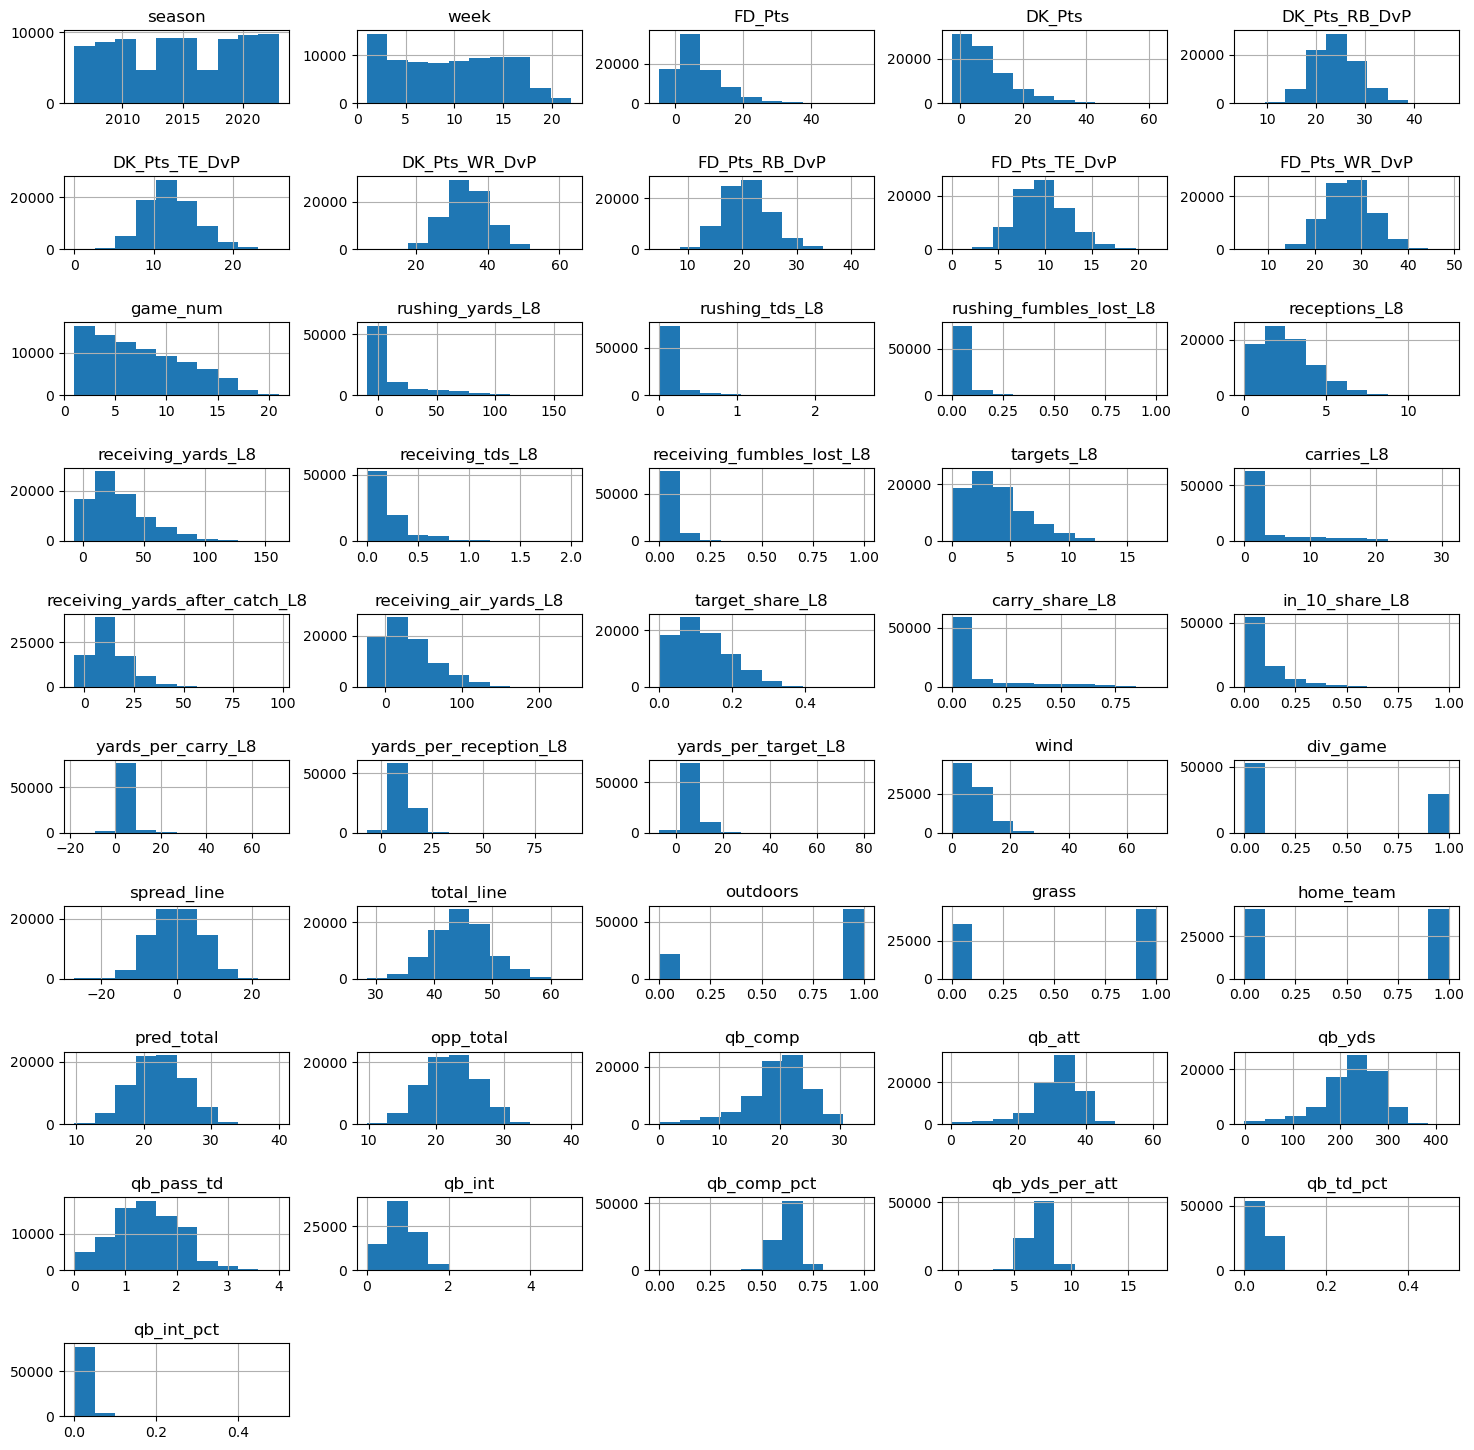

In [316]:
flex_df_all.hist(layout = (10, 5), figsize = (18, 18))
plt.subplots_adjust(hspace=1)
plt.show();

# Filtered for RBs
Some of the medians were really low for these variables below. That's because it included WRs and TEs, who don't normally carry the ball. Here's a look at summary statistics for the dataset filtered for RBs.

In [321]:
flex_df_rb = flex_df_all[flex_df_all['position'] == 'RB']

In [322]:
flex_df_rb[['rushing_yards_L8', 'yards_per_carry_L8', 'carry_share_L8']].describe()

,rushing_yards_L8,yards_per_carry_L8,carry_share_L8
count,27576.000000,27576.000000,27576.000000
mean,34.097574,3.982627,0.305340
std,27.880409,1.604751,0.231643
min,-7.000000,-6.000000,0.000000
25%,11.125000,3.352941,0.107587
50%,27.500000,4.060606,0.252375
75%,53.875000,4.673505,0.495781
max,165.250000,41.000000,0.938000


In [323]:
flex_df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82256 entries, 0 to 82255
Data columns (total 52 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          82256 non-null  int64  
 1   week                            82256 non-null  int64  
 2   team                            82256 non-null  object 
 3   opponent_team                   82256 non-null  object 
 4   player_id                       82256 non-null  object 
 5   player_display_name             82256 non-null  object 
 6   position                        82256 non-null  object 
 7   FD_Pts                          82256 non-null  float64
 8   DK_Pts                          82256 non-null  float64
 9   DK_Pts_RB_DvP                   82256 non-null  float64
 10  DK_Pts_TE_DvP                   82256 non-null  float64
 11  DK_Pts_WR_DvP                   82256 non-null  float64
 12  FD_Pts_RB_DvP                   

In [326]:
flex_df_all.drop(['game_num', 'opponent_team'], axis=1, inplace=True)

In [328]:
flex_df_all.dropna(inplace = True)

In [329]:
flex_df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80815 entries, 226 to 82255
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   season                          80815 non-null  int64  
 1   week                            80815 non-null  int64  
 2   team                            80815 non-null  object 
 3   player_id                       80815 non-null  object 
 4   player_display_name             80815 non-null  object 
 5   position                        80815 non-null  object 
 6   FD_Pts                          80815 non-null  float64
 7   DK_Pts                          80815 non-null  float64
 8   DK_Pts_RB_DvP                   80815 non-null  float64
 9   DK_Pts_TE_DvP                   80815 non-null  float64
 10  DK_Pts_WR_DvP                   80815 non-null  float64
 11  FD_Pts_RB_DvP                   80815 non-null  float64
 12  FD_Pts_TE_DvP                   808

In [330]:
# Establish a connection to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

# Define the table name
table_name = 'flex_dataset'

# Specify data types
dtype = {
    'season': 'INTEGER',
    'week': 'INTEGER',
    'team': 'TEXT',
    'player_id': 'TEXT',
    'player_display_name': 'TEXT',
    'position': 'TEXT',
    'FD_Pts': 'REAL',
    'DK_Pts': 'REAL',
    'DK_Pts_RB_DvP': 'REAL',
    'DK_Pts_TE_DvP': 'REAL',
    'DK_Pts_WR_DvP': 'REAL',
    'FD_Pts_RB_DvP': 'REAL',
    'FD_Pts_TE_DvP': 'REAL',
    'FD_Pts_WR_DvP': 'REAL',
    'rushing_yards_L8': 'REAL',
    'rushing_tds_L8': 'REAL',
    'rushing_fumbles_lost_L8': 'REAL',
    'receptions_L8': 'REAL',
    'receiving_yards_L8': 'REAL',
    'receiving_tds_L8': 'REAL',
    'receiving_fumbles_lost_L8': 'REAL',
    'targets_L8': 'REAL',
    'carries_L8': 'REAL',
    'receiving_yards_after_catch_L8': 'REAL',
    'receiving_air_yards_L8': 'REAL',
    'target_share_L8': 'REAL',
    'carry_share_L8': 'REAL',
    'in_10_share_L8': 'REAL',
    'yards_per_carry_L8': 'REAL',
    'yards_per_reception_L8': 'REAL',
    'yards_per_target_L8': 'REAL',
    'wind': 'REAL',
    'div_game': 'INTEGER',
    'opponent': 'TEXT',
    'spread_line': 'REAL',
    'total_line': 'REAL',
    'outdoors': 'INTEGER',
    'grass': 'INTEGER',
    'home_team': 'INTEGER',
    'pred_total': 'REAL',
    'opp_total': 'REAL',
    'qb_comp': 'REAL',
    'qb_att': 'REAL',
    'qb_yds': 'REAL',
    'qb_pass_td': 'REAL',
    'qb_int': 'REAL',
    'qb_comp_pct': 'REAL',
    'qb_yds_per_att': 'REAL',
    'qb_td_pct': 'REAL',
    'qb_int_pct': 'REAL'
}

# Write the DataFrame to the SQLite table
flex_df_all.to_sql(table_name, conn, if_exists='replace', index=False, dtype=dtype)

# Confirm that the data has been written
print(f"Data written to table {table_name} in SQLite database nfl_dfs.db")

# Close the connection
conn.close()


Data written to table flex_dataset in SQLite database nfl_dfs.db
